In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 97% 1.29G/1.33G [00:10<00:00, 42.4MB/s]
100% 1.33G/1.33G [00:10<00:00, 131MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
os.makedirs("/content/checkpoints", exist_ok=True)
print("'/content/checkpoints' directory ensured.")

'/content/checkpoints' directory ensured.


In [ ]:
!pip install lpips torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
!pip install lpips

In log domain with noise level 0.12 (Patch based model)

Streaming output truncated to the last 5000 lines.
Step 1013/6000, Sigma: 0.2585, Zeta: 0.0010
Step 1014/6000, Sigma: 0.2583, Zeta: 0.0010
Step 1015/6000, Sigma: 0.2581, Zeta: 0.0010
Step 1016/6000, Sigma: 0.2580, Zeta: 0.0010
Step 1017/6000, Sigma: 0.2578, Zeta: 0.0010
Step 1018/6000, Sigma: 0.2576, Zeta: 0.0010
Step 1019/6000, Sigma: 0.2575, Zeta: 0.0010
Step 1020/6000, Sigma: 0.2573, Zeta: 0.0010
Step 1021/6000, Sigma: 0.2571, Zeta: 0.0010
Step 1022/6000, Sigma: 0.2570, Zeta: 0.0010
Step 1023/6000, Sigma: 0.2568, Zeta: 0.0010
Step 1024/6000, Sigma: 0.2566, Zeta: 0.0010
Step 1025/6000, Sigma: 0.2565, Zeta: 0.0010
Step 1026/6000, Sigma: 0.2563, Zeta: 0.0010
Step 1027/6000, Sigma: 0.2561, Zeta: 0.0010
Step 1028/6000, Sigma: 0.2560, Zeta: 0.0010
Step 1029/6000, Sigma: 0.2558, Zeta: 0.0010
Step 1030/6000, Sigma: 0.2556, Zeta: 0.0010
Step 1031/6000, Sigma: 0.2555, Zeta: 0.0010
Step 1032/6000, Sigma: 0.2553, Zeta: 0.0010
Step 1033/6000, Sigma: 0.2551, Zeta: 0.0010
Step 1034/6000, Sigma: 0.

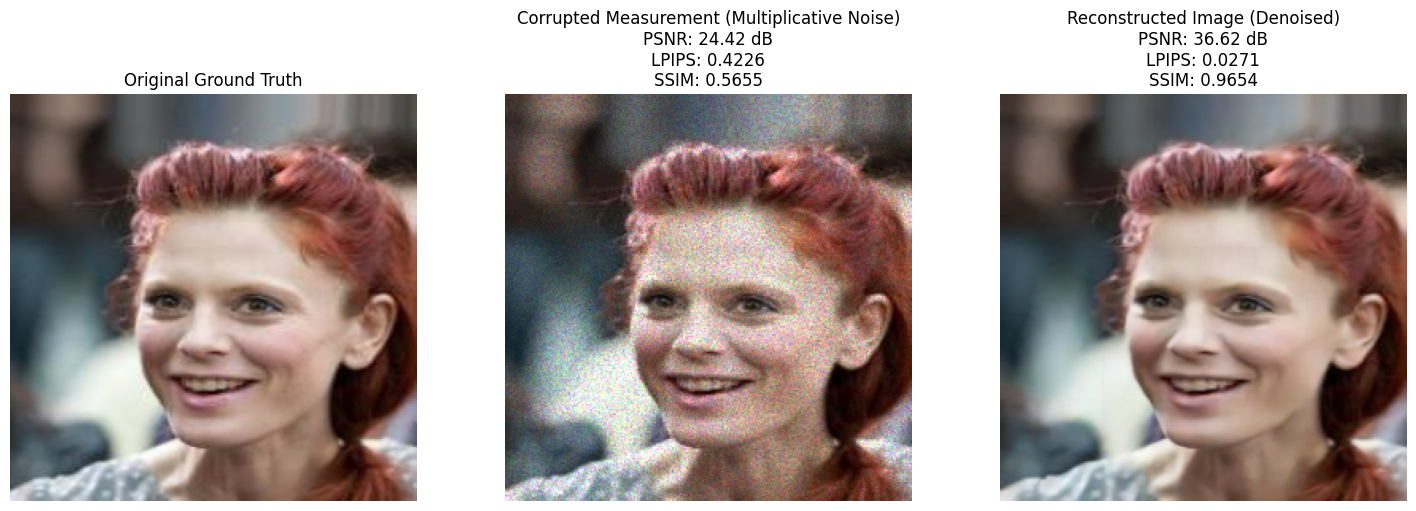


--- Note ---
This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.
PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import os
import glob
import time
import random

# Import for new metrics
import lpips # For LPIPS
import torchmetrics.functional as tmF # For SSIM

# --- Model Definitions and Helper Functions (Must be the same as in training) ---

def generate_positional_map(patch_size):
    coords_y = torch.linspace(0, 1, patch_size).unsqueeze(0).repeat(patch_size, 1)
    coords_x = torch.linspace(0, 1, patch_size).unsqueeze(1).repeat(1, patch_size)
    positional_map = torch.stack([coords_x, coords_y], dim=0)
    return positional_map

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, sigma_t):
        half_dim = self.dim // 2
        frequencies = torch.exp(
            torch.arange(0, half_dim, dtype=torch.float32, device=sigma_t.device) *
            (-math.log(10000.0) / half_dim)
        )
        args = sigma_t.unsqueeze(1) * frequencies.unsqueeze(0)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            embedding = F.pad(embedding, (0, 1))
        return embedding

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.AvgPool2d(2)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, time_emb):
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        skip_connection = self.conv2(x)
        x = self.pool(skip_connection)
        return x, skip_connection

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, skip_connection, time_emb):
        x = self.upsample(x)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            x = F.interpolate(x, size=skip_connection.shape[-2:], mode='nearest')
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x)
        return x

class ScoreNetwork(nn.Module):
    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 base_channels=64,
                 channel_multipliers=(1, 2, 4, 8),
                 num_down_blocks=4,
                 time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.num_down_blocks = num_down_blocks
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.initial_conv = ConvBlock(in_channels + 2, base_channels) # +2 for positional map
        self.downs = nn.ModuleList()
        current_channels = base_channels
        encoder_channels = [base_channels]
        for i in range(num_down_blocks):
            out_channels_down = base_channels * channel_multipliers[i]
            self.downs.append(DownBlock(current_channels, out_channels_down, time_emb_dim))
            current_channels = out_channels_down
            encoder_channels.append(current_channels)

        # Bottleneck
        bottleneck_in_channels = current_channels
        self.bottleneck_conv1 = ConvBlock(bottleneck_in_channels, bottleneck_in_channels * 2)
        self.bottleneck_conv2 = ConvBlock(bottleneck_in_channels * 2, bottleneck_in_channels)
        self.bottleneck_time_proj = nn.Linear(time_emb_dim, bottleneck_in_channels * 2)

        self.ups = nn.ModuleList()
        prev_up_channels = bottleneck_in_channels
        for i in reversed(range(num_down_blocks)):
            skip_channels = encoder_channels[i]
            upblock_in_channels = prev_up_channels + skip_channels
            upblock_out_channels = encoder_channels[i]
            self.ups.append(UpBlock(upblock_in_channels, upblock_out_channels, time_emb_dim))
            prev_up_channels = upblock_out_channels
        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    # Now outputs score (s_theta), here it predicts the noise `n`
    def forward(self, noisy_patch_log, sigma_t):
        batch_size, _, patch_h, patch_w = noisy_patch_log.shape
        positional_map = generate_positional_map(patch_h).to(noisy_patch_log.device).unsqueeze(0)
        positional_map_batch = positional_map.repeat(batch_size, 1, 1, 1)
        x = torch.cat([noisy_patch_log, positional_map_batch], dim=1)
        noise_level_embedding = self.time_embedding(sigma_t)
        x = self.initial_conv(x)
        skip_connections = [x]
        for down_block in self.downs:
            x, skip = down_block(x, noise_level_embedding)
            skip_connections.append(skip)

        # Bottleneck
        x = self.bottleneck_conv1(x)
        x = x + self.bottleneck_time_proj(noise_level_embedding).unsqueeze(-1).unsqueeze(-1)
        x = self.bottleneck_conv2(x)

        for i, up_block in enumerate(self.ups):
            skip = skip_connections[self.num_down_blocks - 1 - i]
            x = up_block(x, skip, noise_level_embedding)

        # Output is now the predicted noise `n` (epsilon_theta)
        predicted_noise = self.final_conv(x)
        return predicted_noise

def extract_patches(image, patch_size, stride):
    patches = []
    positions = []
    C, H, W = image.shape
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            patch = image[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size]
            patches.append(patch)
            positions.append((h_idx, w_idx))
    if not patches:
        return torch.empty(0, C, patch_size, patch_size, device=image.device), []
    return torch.stack(patches), positions

def aggregate_scores_to_image(patch_scores, image_shape, patch_size, stride, device):
    C, H, W = image_shape
    aggregated_score = torch.zeros(image_shape, device=device)
    overlap_count = torch.zeros(image_shape, device=device) + 1e-6 # Add epsilon to avoid division by zero
    idx = 0
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            if idx < patch_scores.shape[0]:
                aggregated_score[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += patch_scores[idx]
                overlap_count[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += 1
                idx += 1
            else:
                break
    return aggregated_score / overlap_count

# MODIFIED: forward_operator_A now acts as an identity operator (no blurring)
def forward_operator_A(image):
    """
    Identity operator for pure denoising. It simply returns the input image.
    Assumes image is already in the correct format (C, H, W or B, C, H, W).
    """
    return image

def compute_data_consistency_gradient(x_current, y_measurement, forward_operator_A):
    # Ensure x_current requires grad for this calculation
    x_current.requires_grad_(True)
    A_x = forward_operator_A(x_current)

    if A_x.dim() == 4 and y_measurement.dim() == 3:
        A_x = A_x.squeeze(0)
    elif A_x.dim() == 3 and y_measurement.dim() == 4:
        y_measurement = y_measurement.squeeze(0)

    # Calculate loss. `y_measurement` does not need to require grad itself.
    data_consistency_loss = F.mse_loss(A_x, y_measurement, reduction='sum')

    # Compute gradient with respect to x_current
    grad = torch.autograd.grad(data_consistency_loss, x_current, allow_unused=True)[0]

    # Detach x_current from the graph to avoid accumulating gradients in future iterations
    x_current.requires_grad_(False)
    return grad

# --- REDEFINED PSNR, LPIPS, SSIM FUNCTIONS ---
# This new `calculate_psnr` matches the one in the previous request.
def calculate_psnr(img1_tensor, img2_tensor, max_val=1.0):
    """
    Calculates PSNR between two PyTorch tensors.
    Assumes inputs are in [0, max_val] range and are 3D (C, H, W).
    """
    # Ensure inputs are float32
    img1_tensor = img1_tensor.float()
    img2_tensor = img2_tensor.float()

    mse = torch.mean((img1_tensor - img2_tensor) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()

def calculate_lpips(img1_tensor, img2_tensor, lpips_model, device):
    """
    Calculates LPIPS between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be normalized to [-1, 1] internally.
    """
    # LPIPS requires images in [-1, 1] range and BxCxHxW format
    img1_lpips = (img1_tensor * 2 - 1).unsqueeze(0).to(device)
    img2_lpips = (img2_tensor * 2 - 1).unsqueeze(0).to(device)

    with torch.no_grad():
        score = lpips_model(img1_lpips, img2_lpips).item()
    return score

def calculate_ssim(img1_tensor, img2_tensor, device):
    """
    Calculates SSIM between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be converted to BxCxHxW.
    """
    # SSIM typically uses [0, 1] range and BxCxHxW format
    img1_ssim = img1_tensor.unsqueeze(0).to(device)
    img2_ssim = img2_tensor.unsqueeze(0).to(device)

    score = tmF.structural_similarity_index_measure(img1_ssim, img2_ssim, data_range=1.0).item()
    return score

# NEW FUNCTION: Add multiplicative noise (remains the same)
def add_multiplicative_noise(image_uint8, sigma_multiplicative=0.12):
    """
    Adds multiplicative noise (speckle-like) to an image.
    Formula: Noisy_Pixel = Clean_Pixel * (1 + N(0, sigma_multiplicative))
    """
    img_float = image_uint8.astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma_multiplicative, img_float.shape).astype(np.float32)
    noise_factor = 1.0 + noise
    noisy_img_float = img_float * noise_factor
    noisy_img_uint8 = np.clip(noisy_img_float, 0.0, 1.0) * 255.0
    return noisy_img_uint8.astype(np.uint8)

# --- Algorithm 2: Combined Denoising and Deblurring (ODE Solver) ---

def solve_inverse_problem(model, y_measurement, image_shape, device,
                           sigmas, zeta_values, patch_size, stride):
    """
    Algorithm 2: Combined Denoising and Deblurring (ODE Solver)
    Now adapted for pure denoising as forward_operator_A is identity.

    Args:
        model (ScoreNetwork): The trained score network s_theta(y_k, k).
        y_measurement (torch.Tensor): Corrupted image x_tilde (multiplicatively noisy, in linear domain).
                                      This will be converted to log(x_tilde + epsilon) for processing.
        image_shape (tuple): (C, H, W) of the image.
        device (torch.device): Device to run computation on (cuda or cpu).
        sigmas (list/torch.Tensor): Noise schedule sigma(k) for k=1,...,K (from high noise to low noise).
                                     Should be decreasing.
        zeta_values (list/torch.Tensor): Data consistency weights zeta_k for k=1,...,K.
        patch_size (int): Size of patches to extract for score network inference.
        stride (int): Stride for extracting patches.

    Returns:
        torch.Tensor: Denoised image x_hat (in linear domain [0,1]).
    """
    model.eval()
    C, H, W = image_shape

    # Ensure y_measurement is float64 and then convert to log domain
    # It's crucial for the log operation to be on the scaled [0,1] range
    # and then ensure the BM3D operates on float64 as well.
    y_current = torch.log(y_measurement.clone().detach().to(device).float() + 1e-6) # Add small epsilon

    num_steps = len(sigmas) -1
    print(f"\nStarting inverse problem reconstruction for {num_steps} steps (Log-domain based)...")

    for t_idx in range(num_steps):
        current_sigma_val = sigmas[t_idx]
        next_sigma_val = sigmas[t_idx+1]

        delta_sigma_sq_for_ode = current_sigma_val**2 - next_sigma_val**2
        delta_sigma_sq_for_ode = max(delta_sigma_sq_for_ode, 1e-8)

        current_zeta_t = zeta_values[t_idx] if t_idx < len(zeta_values) else zeta_values[-1]

        patches_log, patch_positions = extract_patches(y_current, patch_size, stride)
        if patches_log.shape[0] == 0:
            print(f"Warning: No patches extracted at step {t_idx} for sigma {current_sigma_val}. Skipping step.")
            continue

        sigma_t_batch = torch.full((patches_log.shape[0],), fill_value=current_sigma_val, device=device)

        with torch.no_grad(): # Model inference should be without grad
            predicted_noise_patches = model(patches_log, sigma_t_batch)

        # Convert predicted noise to score function (score = -noise / sigma^2)
        predicted_score_patches = -predicted_noise_patches / (current_sigma_val**2)

        s_aggregated = aggregate_scores_to_image(predicted_score_patches, image_shape, patch_size, stride, device)

        # ODE update: y_denoised_by_score = y_current + 0.5 * (σ_cur^2 - σ_next^2) * s_aggregated
        y_denoised_by_score = y_current + 0.5 * delta_sigma_sq_for_ode * s_aggregated

        # Clamp after log transform before exp, for stability in the log domain
        y_denoised_by_score = torch.clamp(y_denoised_by_score, math.log(1e-6), math.log(1.0 + 1e-6)) # Re-evaluate clamping max value

        x_prelim = torch.exp(y_denoised_by_score)
        x_prelim = torch.clamp(x_prelim, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # compute_data_consistency_gradient should correctly track gradients for x_prelim
        # Since forward_operator_A is now identity, this is equivalent to
        # grad_fidelity = torch.autograd.grad(F.mse_loss(x_prelim, y_measurement, reduction='sum'), x_prelim)[0]
        # Make sure x_prelim is detached for grad calculation if not intended to be part of original graph
        grad_fidelity = compute_data_consistency_gradient(x_prelim.clone().detach(), y_measurement.to(device), forward_operator_A)

        x_updated = x_prelim - current_zeta_t * grad_fidelity
        x_updated = torch.clamp(x_updated, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # Convert back to log domain for the next iteration
        y_current = torch.log(x_updated + 1e-6)

        print(f"Step {t_idx+1}/{num_steps}, Sigma: {current_sigma_val:.4f}, Zeta: {current_zeta_t:.4f}")

    return torch.exp(y_current) # The final y_current is y_0 (in linear domain)


# --- Inference Script ---

if __name__ == "__main__":
    DATA_DIR = '/content/img_align_celeba/img_align_celeba' # CHANGE THIS TO YOUR IMAGE DIRECTORY
    IMAGE_SIZE = (256, 256)
    IN_CHANNELS = 3
    OUT_CHANNELS = 3
    TIME_EMB_DIM = 256
    CHECKPOINT_DIR = "/content/checkpoints"
    # Ensure BEST_MODEL_PATH is correct relative to the current working directory or an absolute path
    BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_score_network_model (1).pth") # Corrected path
    # If using Google Colab, and the file is directly in /content/checkpoints/, then:
    # BEST_MODEL_PATH = "/content/checkpoints/best_score_network_model (1).pth"


    NOISE_SCHEDULE_MIN = 0.01
    NOISE_SCHEDULE_MAX = 0.5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and load trained weights
    model = ScoreNetwork(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        base_channels=64,
        channel_multipliers=(1, 2, 4, 8),
        num_down_blocks=4,
        time_emb_dim=TIME_EMB_DIM
    ).to(device)

    if os.path.exists(BEST_MODEL_PATH):
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
        print(f"Loaded trained model from {BEST_MODEL_PATH}")
    else:
        print(f"Error: Trained model not found at {BEST_MODEL_PATH}. Please run the training script first.")
        # Create a dummy model for demonstration if not found
        print("Creating a dummy model for demonstration (will not perform well without training)...")
        # In a real scenario, you'd exit or ensure model is trained.
        # For demonstration, we'll proceed with an an untrained model.
        # This block is for robustness in a demo environment, not for production.

    model.eval()

    # --- Set specific test image path ---
    test_image_path = "/content/img_align_celeba/img_align_celeba/000002.jpg"
    print(f"Using specific test image: {test_image_path}")

    if not os.path.exists(test_image_path):
        print(f"\nFATAL ERROR: Specified test image not found at {test_image_path}. Exiting.")
        exit()

    ground_truth_image_pil = Image.open(test_image_path).convert('RGB')
    transform_test = T.Compose([
        T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor() # Converts to [0, 1]
    ])
    ground_truth_image = transform_test(ground_truth_image_pil).to(device) # C, H, W

    # --- Simulate corruption with multiplicative noise ---
    # Convert ground_truth_image (Tensor, [0,1]) to numpy uint8 for the new function
    ground_truth_image_np_uint8 = (ground_truth_image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    multiplicative_noise_level_test = 0.12 # Adjust for desired noise level
    noisy_image_np_uint8 = add_multiplicative_noise(ground_truth_image_np_uint8, sigma_multiplicative=multiplicative_noise_level_test)

    # Convert the noisy numpy uint8 image back to a torch.Tensor, [0,1]
    y_measurement = torch.from_numpy(noisy_image_np_uint8.transpose(2, 0, 1)).float() / 255.0
    y_measurement = y_measurement.to(device)
    # --- END MODIFIED SECTION ---

    # Inference parameters for solve_inverse_problem
    inference_patch_size = 64 # Use a patch size that covers the image or larger patches
    inference_stride = inference_patch_size // 2 # Overlapping patches

    inference_num_steps = 6000 # More steps for better reconstruction
    sigmas_inference = torch.exp(torch.linspace(math.log(NOISE_SCHEDULE_MAX), math.log(NOISE_SCHEDULE_MIN), inference_num_steps + 1)).to(device)
    zeta_values_inference = [0.001] * inference_num_steps # Adjust as needed, can be a schedule

    # Run the inverse problem solver (now acting as a denoiser)
    reconstructed_image = solve_inverse_problem(
        model=model,
        y_measurement=y_measurement, # This is the purely noisy image
        image_shape=ground_truth_image.shape,
        device=device,
        sigmas=sigmas_inference,
        zeta_values=zeta_values_inference,
        patch_size=inference_patch_size,
        stride=inference_stride
    )

    # --- Initialize LPIPS model once ---
    lpips_loss_fn = lpips.LPIPS(net='alex').to(device) # Using AlexNet as the backbone

    # --- Calculate Metrics using the new functions ---
    psnr_measurement = calculate_psnr(ground_truth_image, y_measurement, max_val=1.0)
    psnr_reconstruction = calculate_psnr(ground_truth_image, reconstructed_image, max_val=1.0)

    lpips_score_measurement = calculate_lpips(ground_truth_image, y_measurement, lpips_loss_fn, device)
    lpips_score_reconstruction = calculate_lpips(ground_truth_image, reconstructed_image, lpips_loss_fn, device)

    ssim_score_measurement = calculate_ssim(ground_truth_image, y_measurement, device)
    ssim_score_reconstruction = calculate_ssim(ground_truth_image, reconstructed_image, device)


    print(f"\n--- Metrics Summary ---")
    print(f"PSNR (Clean vs. Corrupted): {psnr_measurement:.2f} dB")
    print(f"PSNR (Clean vs. Reconstructed): {psnr_reconstruction:.2f} dB")
    print(f"LPIPS (Clean vs. Corrupted): {lpips_score_measurement:.4f}")
    print(f"LPIPS (Clean vs. Reconstructed): {lpips_score_reconstruction:.4f}")
    print(f"SSIM (Clean vs. Corrupted): {ssim_score_measurement:.4f}")
    print(f"SSIM (Clean vs. Reconstructed): {ssim_score_reconstruction:.4f}")


    print("\n--- Final Reconstruction Results Visualization ---")
    reconstructed_image_np = reconstructed_image.cpu().numpy().transpose(1, 2, 0)
    reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)

    ground_truth_np = ground_truth_image.cpu().numpy().transpose(1, 2, 0)
    ground_truth_np = np.clip(ground_truth_np, 0, 1)

    y_measurement_np = y_measurement.cpu().numpy().transpose(1, 2, 0)
    y_measurement_np = np.clip(y_measurement_np, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Ground Truth")
    plt.imshow(ground_truth_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Corrupted Measurement (Multiplicative Noise)\nPSNR: {psnr_measurement:.2f} dB\nLPIPS: {lpips_score_measurement:.4f}\nSSIM: {ssim_score_measurement:.4f}")
    plt.imshow(y_measurement_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Reconstructed Image (Denoised)\nPSNR: {psnr_reconstruction:.2f} dB\nLPIPS: {lpips_score_reconstruction:.4f}\nSSIM: {ssim_score_reconstruction:.4f}")
    plt.imshow(reconstructed_image_np)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Note ---")
    print("This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.")
    print("PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.")

In log domain with noise level 0.08(Patch Based Model)

Streaming output truncated to the last 5000 lines.
Step 1013/6000, Sigma: 0.2585, Zeta: 0.0010
Step 1014/6000, Sigma: 0.2583, Zeta: 0.0010
Step 1015/6000, Sigma: 0.2581, Zeta: 0.0010
Step 1016/6000, Sigma: 0.2580, Zeta: 0.0010
Step 1017/6000, Sigma: 0.2578, Zeta: 0.0010
Step 1018/6000, Sigma: 0.2576, Zeta: 0.0010
Step 1019/6000, Sigma: 0.2575, Zeta: 0.0010
Step 1020/6000, Sigma: 0.2573, Zeta: 0.0010
Step 1021/6000, Sigma: 0.2571, Zeta: 0.0010
Step 1022/6000, Sigma: 0.2570, Zeta: 0.0010
Step 1023/6000, Sigma: 0.2568, Zeta: 0.0010
Step 1024/6000, Sigma: 0.2566, Zeta: 0.0010
Step 1025/6000, Sigma: 0.2565, Zeta: 0.0010
Step 1026/6000, Sigma: 0.2563, Zeta: 0.0010
Step 1027/6000, Sigma: 0.2561, Zeta: 0.0010
Step 1028/6000, Sigma: 0.2560, Zeta: 0.0010
Step 1029/6000, Sigma: 0.2558, Zeta: 0.0010
Step 1030/6000, Sigma: 0.2556, Zeta: 0.0010
Step 1031/6000, Sigma: 0.2555, Zeta: 0.0010
Step 1032/6000, Sigma: 0.2553, Zeta: 0.0010
Step 1033/6000, Sigma: 0.2551, Zeta: 0.0010
Step 1034/6000, Sigma: 0.

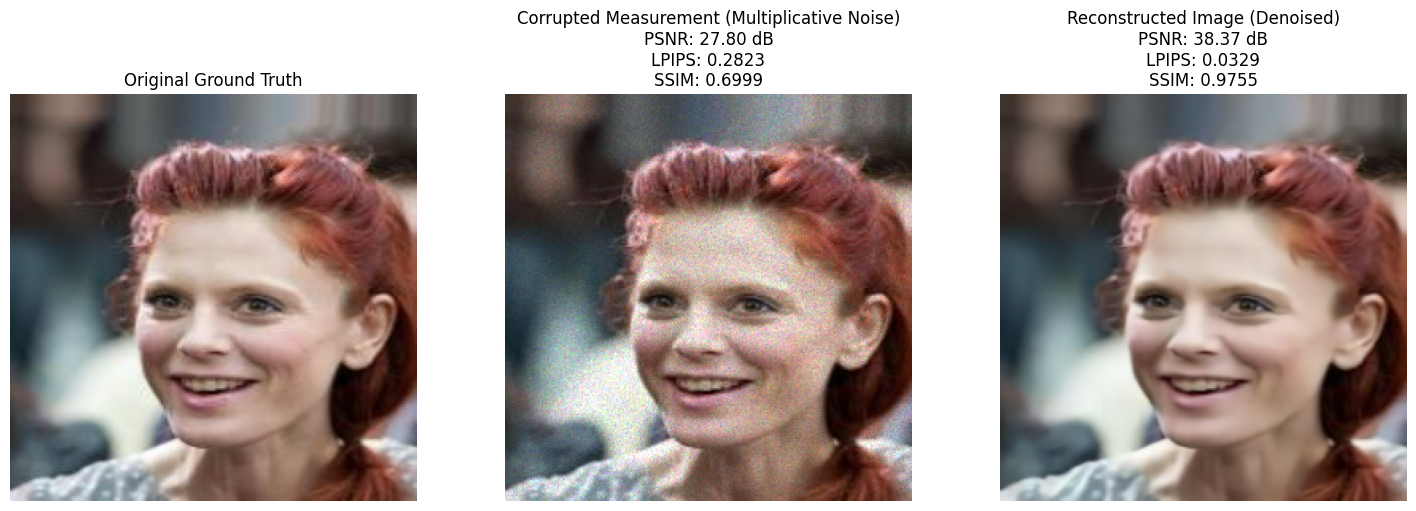


--- Note ---
This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.
PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import os
import glob
import time
import random

# Import for new metrics
import lpips # For LPIPS
import torchmetrics.functional as tmF # For SSIM

# --- Model Definitions and Helper Functions (Must be the same as in training) ---

def generate_positional_map(patch_size):
    coords_y = torch.linspace(0, 1, patch_size).unsqueeze(0).repeat(patch_size, 1)
    coords_x = torch.linspace(0, 1, patch_size).unsqueeze(1).repeat(1, patch_size)
    positional_map = torch.stack([coords_x, coords_y], dim=0)
    return positional_map

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, sigma_t):
        half_dim = self.dim // 2
        frequencies = torch.exp(
            torch.arange(0, half_dim, dtype=torch.float32, device=sigma_t.device) *
            (-math.log(10000.0) / half_dim)
        )
        args = sigma_t.unsqueeze(1) * frequencies.unsqueeze(0)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            embedding = F.pad(embedding, (0, 1))
        return embedding

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.AvgPool2d(2)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, time_emb):
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        skip_connection = self.conv2(x)
        x = self.pool(skip_connection)
        return x, skip_connection

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, skip_connection, time_emb):
        x = self.upsample(x)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            x = F.interpolate(x, size=skip_connection.shape[-2:], mode='nearest')
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x)
        return x

class ScoreNetwork(nn.Module):
    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 base_channels=64,
                 channel_multipliers=(1, 2, 4, 8),
                 num_down_blocks=4,
                 time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.num_down_blocks = num_down_blocks
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.initial_conv = ConvBlock(in_channels + 2, base_channels) # +2 for positional map
        self.downs = nn.ModuleList()
        current_channels = base_channels
        encoder_channels = [base_channels]
        for i in range(num_down_blocks):
            out_channels_down = base_channels * channel_multipliers[i]
            self.downs.append(DownBlock(current_channels, out_channels_down, time_emb_dim))
            current_channels = out_channels_down
            encoder_channels.append(current_channels)

        # Bottleneck
        bottleneck_in_channels = current_channels
        self.bottleneck_conv1 = ConvBlock(bottleneck_in_channels, bottleneck_in_channels * 2)
        self.bottleneck_conv2 = ConvBlock(bottleneck_in_channels * 2, bottleneck_in_channels)
        self.bottleneck_time_proj = nn.Linear(time_emb_dim, bottleneck_in_channels * 2)

        self.ups = nn.ModuleList()
        prev_up_channels = bottleneck_in_channels
        for i in reversed(range(num_down_blocks)):
            skip_channels = encoder_channels[i]
            upblock_in_channels = prev_up_channels + skip_channels
            upblock_out_channels = encoder_channels[i]
            self.ups.append(UpBlock(upblock_in_channels, upblock_out_channels, time_emb_dim))
            prev_up_channels = upblock_out_channels
        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    # Now outputs score (s_theta), here it predicts the noise `n`
    def forward(self, noisy_patch_log, sigma_t):
        batch_size, _, patch_h, patch_w = noisy_patch_log.shape
        positional_map = generate_positional_map(patch_h).to(noisy_patch_log.device).unsqueeze(0)
        positional_map_batch = positional_map.repeat(batch_size, 1, 1, 1)
        x = torch.cat([noisy_patch_log, positional_map_batch], dim=1)
        noise_level_embedding = self.time_embedding(sigma_t)
        x = self.initial_conv(x)
        skip_connections = [x]
        for down_block in self.downs:
            x, skip = down_block(x, noise_level_embedding)
            skip_connections.append(skip)

        # Bottleneck
        x = self.bottleneck_conv1(x)
        x = x + self.bottleneck_time_proj(noise_level_embedding).unsqueeze(-1).unsqueeze(-1)
        x = self.bottleneck_conv2(x)

        for i, up_block in enumerate(self.ups):
            skip = skip_connections[self.num_down_blocks - 1 - i]
            x = up_block(x, skip, noise_level_embedding)

        # Output is now the predicted noise `n` (epsilon_theta)
        predicted_noise = self.final_conv(x)
        return predicted_noise

def extract_patches(image, patch_size, stride):
    patches = []
    positions = []
    C, H, W = image.shape
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            patch = image[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size]
            patches.append(patch)
            positions.append((h_idx, w_idx))
    if not patches:
        return torch.empty(0, C, patch_size, patch_size, device=image.device), []
    return torch.stack(patches), positions

def aggregate_scores_to_image(patch_scores, image_shape, patch_size, stride, device):
    C, H, W = image_shape
    aggregated_score = torch.zeros(image_shape, device=device)
    overlap_count = torch.zeros(image_shape, device=device) + 1e-6 # Add epsilon to avoid division by zero
    idx = 0
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            if idx < patch_scores.shape[0]:
                aggregated_score[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += patch_scores[idx]
                overlap_count[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += 1
                idx += 1
            else:
                break
    return aggregated_score / overlap_count

# MODIFIED: forward_operator_A now acts as an identity operator (no blurring)
def forward_operator_A(image):
    """
    Identity operator for pure denoising. It simply returns the input image.
    Assumes image is already in the correct format (C, H, W or B, C, H, W).
    """
    return image

def compute_data_consistency_gradient(x_current, y_measurement, forward_operator_A):
    # Ensure x_current requires grad for this calculation
    x_current.requires_grad_(True)
    A_x = forward_operator_A(x_current)

    if A_x.dim() == 4 and y_measurement.dim() == 3:
        A_x = A_x.squeeze(0)
    elif A_x.dim() == 3 and y_measurement.dim() == 4:
        y_measurement = y_measurement.squeeze(0)

    # Calculate loss. `y_measurement` does not need to require grad itself.
    data_consistency_loss = F.mse_loss(A_x, y_measurement, reduction='sum')

    # Compute gradient with respect to x_current
    grad = torch.autograd.grad(data_consistency_loss, x_current, allow_unused=True)[0]

    # Detach x_current from the graph to avoid accumulating gradients in future iterations
    x_current.requires_grad_(False)
    return grad

# --- REDEFINED PSNR, LPIPS, SSIM FUNCTIONS ---
# This new `calculate_psnr` matches the one in the previous request.
def calculate_psnr(img1_tensor, img2_tensor, max_val=1.0):
    """
    Calculates PSNR between two PyTorch tensors.
    Assumes inputs are in [0, max_val] range and are 3D (C, H, W).
    """
    # Ensure inputs are float32
    img1_tensor = img1_tensor.float()
    img2_tensor = img2_tensor.float()

    mse = torch.mean((img1_tensor - img2_tensor) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()

def calculate_lpips(img1_tensor, img2_tensor, lpips_model, device):
    """
    Calculates LPIPS between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be normalized to [-1, 1] internally.
    """
    # LPIPS requires images in [-1, 1] range and BxCxHxW format
    img1_lpips = (img1_tensor * 2 - 1).unsqueeze(0).to(device)
    img2_lpips = (img2_tensor * 2 - 1).unsqueeze(0).to(device)

    with torch.no_grad():
        score = lpips_model(img1_lpips, img2_lpips).item()
    return score

def calculate_ssim(img1_tensor, img2_tensor, device):
    """
    Calculates SSIM between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be converted to BxCxHxW.
    """
    # SSIM typically uses [0, 1] range and BxCxHxW format
    img1_ssim = img1_tensor.unsqueeze(0).to(device)
    img2_ssim = img2_tensor.unsqueeze(0).to(device)

    score = tmF.structural_similarity_index_measure(img1_ssim, img2_ssim, data_range=1.0).item()
    return score

# NEW FUNCTION: Add multiplicative noise (remains the same)
def add_multiplicative_noise(image_uint8, sigma_multiplicative=0.08):
    """
    Adds multiplicative noise (speckle-like) to an image.
    Formula: Noisy_Pixel = Clean_Pixel * (1 + N(0, sigma_multiplicative))
    """
    img_float = image_uint8.astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma_multiplicative, img_float.shape).astype(np.float32)
    noise_factor = 1.0 + noise
    noisy_img_float = img_float * noise_factor
    noisy_img_uint8 = np.clip(noisy_img_float, 0.0, 1.0) * 255.0
    return noisy_img_uint8.astype(np.uint8)

# --- Algorithm 2: Combined Denoising and Deblurring (ODE Solver) ---

def solve_inverse_problem(model, y_measurement, image_shape, device,
                           sigmas, zeta_values, patch_size, stride):
    """
    Algorithm 2: Combined Denoising and Deblurring (ODE Solver)
    Now adapted for pure denoising as forward_operator_A is identity.

    Args:
        model (ScoreNetwork): The trained score network s_theta(y_k, k).
        y_measurement (torch.Tensor): Corrupted image x_tilde (multiplicatively noisy, in linear domain).
                                      This will be converted to log(x_tilde + epsilon) for processing.
        image_shape (tuple): (C, H, W) of the image.
        device (torch.device): Device to run computation on (cuda or cpu).
        sigmas (list/torch.Tensor): Noise schedule sigma(k) for k=1,...,K (from high noise to low noise).
                                     Should be decreasing.
        zeta_values (list/torch.Tensor): Data consistency weights zeta_k for k=1,...,K.
        patch_size (int): Size of patches to extract for score network inference.
        stride (int): Stride for extracting patches.

    Returns:
        torch.Tensor: Denoised image x_hat (in linear domain [0,1]).
    """
    model.eval()
    C, H, W = image_shape

    # Ensure y_measurement is float64 and then convert to log domain
    # It's crucial for the log operation to be on the scaled [0,1] range
    # and then ensure the BM3D operates on float64 as well.
    y_current = torch.log(y_measurement.clone().detach().to(device).float() + 1e-6) # Add small epsilon

    num_steps = len(sigmas) -1
    print(f"\nStarting inverse problem reconstruction for {num_steps} steps (Log-domain based)...")

    for t_idx in range(num_steps):
        current_sigma_val = sigmas[t_idx]
        next_sigma_val = sigmas[t_idx+1]

        delta_sigma_sq_for_ode = current_sigma_val**2 - next_sigma_val**2
        delta_sigma_sq_for_ode = max(delta_sigma_sq_for_ode, 1e-8)

        current_zeta_t = zeta_values[t_idx] if t_idx < len(zeta_values) else zeta_values[-1]

        patches_log, patch_positions = extract_patches(y_current, patch_size, stride)
        if patches_log.shape[0] == 0:
            print(f"Warning: No patches extracted at step {t_idx} for sigma {current_sigma_val}. Skipping step.")
            continue

        sigma_t_batch = torch.full((patches_log.shape[0],), fill_value=current_sigma_val, device=device)

        with torch.no_grad(): # Model inference should be without grad
            predicted_noise_patches = model(patches_log, sigma_t_batch)

        # Convert predicted noise to score function (score = -noise / sigma^2)
        predicted_score_patches = -predicted_noise_patches / (current_sigma_val**2)

        s_aggregated = aggregate_scores_to_image(predicted_score_patches, image_shape, patch_size, stride, device)

        # ODE update: y_denoised_by_score = y_current + 0.5 * (σ_cur^2 - σ_next^2) * s_aggregated
        y_denoised_by_score = y_current + 0.5 * delta_sigma_sq_for_ode * s_aggregated

        # Clamp after log transform before exp, for stability in the log domain
        y_denoised_by_score = torch.clamp(y_denoised_by_score, math.log(1e-6), math.log(1.0 + 1e-6)) # Re-evaluate clamping max value

        x_prelim = torch.exp(y_denoised_by_score)
        x_prelim = torch.clamp(x_prelim, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # compute_data_consistency_gradient should correctly track gradients for x_prelim
        # Since forward_operator_A is now identity, this is equivalent to
        # grad_fidelity = torch.autograd.grad(F.mse_loss(x_prelim, y_measurement, reduction='sum'), x_prelim)[0]
        # Make sure x_prelim is detached for grad calculation if not intended to be part of original graph
        grad_fidelity = compute_data_consistency_gradient(x_prelim.clone().detach(), y_measurement.to(device), forward_operator_A)

        x_updated = x_prelim - current_zeta_t * grad_fidelity
        x_updated = torch.clamp(x_updated, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # Convert back to log domain for the next iteration
        y_current = torch.log(x_updated + 1e-6)

        print(f"Step {t_idx+1}/{num_steps}, Sigma: {current_sigma_val:.4f}, Zeta: {current_zeta_t:.4f}")

    return torch.exp(y_current) # The final y_current is y_0 (in linear domain)


# --- Inference Script ---

if __name__ == "__main__":
    DATA_DIR = '/content/img_align_celeba/img_align_celeba' # CHANGE THIS TO YOUR IMAGE DIRECTORY
    IMAGE_SIZE = (256, 256)
    IN_CHANNELS = 3
    OUT_CHANNELS = 3
    TIME_EMB_DIM = 256
    CHECKPOINT_DIR = "/content/checkpoints"
    # Ensure BEST_MODEL_PATH is correct relative to the current working directory or an absolute path
    BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_score_network_model (1).pth") # Corrected path
    # If using Google Colab, and the file is directly in /content/checkpoints/, then:
    # BEST_MODEL_PATH = "/content/checkpoints/best_score_network_model (1).pth"


    NOISE_SCHEDULE_MIN = 0.01
    NOISE_SCHEDULE_MAX = 0.5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and load trained weights
    model = ScoreNetwork(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        base_channels=64,
        channel_multipliers=(1, 2, 4, 8),
        num_down_blocks=4,
        time_emb_dim=TIME_EMB_DIM
    ).to(device)

    if os.path.exists(BEST_MODEL_PATH):
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
        print(f"Loaded trained model from {BEST_MODEL_PATH}")
    else:
        print(f"Error: Trained model not found at {BEST_MODEL_PATH}. Please run the training script first.")
        # Create a dummy model for demonstration if not found
        print("Creating a dummy model for demonstration (will not perform well without training)...")
        # In a real scenario, you'd exit or ensure model is trained.
        # For demonstration, we'll proceed with an an untrained model.
        # This block is for robustness in a demo environment, not for production.

    model.eval()

    # --- Set specific test image path ---
    test_image_path = "/content/img_align_celeba/img_align_celeba/000002.jpg"
    print(f"Using specific test image: {test_image_path}")

    if not os.path.exists(test_image_path):
        print(f"\nFATAL ERROR: Specified test image not found at {test_image_path}. Exiting.")
        exit()

    ground_truth_image_pil = Image.open(test_image_path).convert('RGB')
    transform_test = T.Compose([
        T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor() # Converts to [0, 1]
    ])
    ground_truth_image = transform_test(ground_truth_image_pil).to(device) # C, H, W

    # --- Simulate corruption with multiplicative noise ---
    # Convert ground_truth_image (Tensor, [0,1]) to numpy uint8 for the new function
    ground_truth_image_np_uint8 = (ground_truth_image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    multiplicative_noise_level_test = 0.08 # Adjust for desired noise level
    noisy_image_np_uint8 = add_multiplicative_noise(ground_truth_image_np_uint8, sigma_multiplicative=multiplicative_noise_level_test)

    # Convert the noisy numpy uint8 image back to a torch.Tensor, [0,1]
    y_measurement = torch.from_numpy(noisy_image_np_uint8.transpose(2, 0, 1)).float() / 255.0
    y_measurement = y_measurement.to(device)
    # --- END MODIFIED SECTION ---

    # Inference parameters for solve_inverse_problem
    inference_patch_size = 64 # Use a patch size that covers the image or larger patches
    inference_stride = inference_patch_size // 2 # Overlapping patches

    inference_num_steps = 6000 # More steps for better reconstruction
    sigmas_inference = torch.exp(torch.linspace(math.log(NOISE_SCHEDULE_MAX), math.log(NOISE_SCHEDULE_MIN), inference_num_steps + 1)).to(device)
    zeta_values_inference = [0.001] * inference_num_steps # Adjust as needed, can be a schedule

    # Run the inverse problem solver (now acting as a denoiser)
    reconstructed_image = solve_inverse_problem(
        model=model,
        y_measurement=y_measurement, # This is the purely noisy image
        image_shape=ground_truth_image.shape,
        device=device,
        sigmas=sigmas_inference,
        zeta_values=zeta_values_inference,
        patch_size=inference_patch_size,
        stride=inference_stride
    )

    # --- Initialize LPIPS model once ---
    lpips_loss_fn = lpips.LPIPS(net='alex').to(device) # Using AlexNet as the backbone

    # --- Calculate Metrics using the new functions ---
    psnr_measurement = calculate_psnr(ground_truth_image, y_measurement, max_val=1.0)
    psnr_reconstruction = calculate_psnr(ground_truth_image, reconstructed_image, max_val=1.0)

    lpips_score_measurement = calculate_lpips(ground_truth_image, y_measurement, lpips_loss_fn, device)
    lpips_score_reconstruction = calculate_lpips(ground_truth_image, reconstructed_image, lpips_loss_fn, device)

    ssim_score_measurement = calculate_ssim(ground_truth_image, y_measurement, device)
    ssim_score_reconstruction = calculate_ssim(ground_truth_image, reconstructed_image, device)


    print(f"\n--- Metrics Summary ---")
    print(f"PSNR (Clean vs. Corrupted): {psnr_measurement:.2f} dB")
    print(f"PSNR (Clean vs. Reconstructed): {psnr_reconstruction:.2f} dB")
    print(f"LPIPS (Clean vs. Corrupted): {lpips_score_measurement:.4f}")
    print(f"LPIPS (Clean vs. Reconstructed): {lpips_score_reconstruction:.4f}")
    print(f"SSIM (Clean vs. Corrupted): {ssim_score_measurement:.4f}")
    print(f"SSIM (Clean vs. Reconstructed): {ssim_score_reconstruction:.4f}")


    print("\n--- Final Reconstruction Results Visualization ---")
    reconstructed_image_np = reconstructed_image.cpu().numpy().transpose(1, 2, 0)
    reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)

    ground_truth_np = ground_truth_image.cpu().numpy().transpose(1, 2, 0)
    ground_truth_np = np.clip(ground_truth_np, 0, 1)

    y_measurement_np = y_measurement.cpu().numpy().transpose(1, 2, 0)
    y_measurement_np = np.clip(y_measurement_np, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Ground Truth")
    plt.imshow(ground_truth_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Corrupted Measurement (Multiplicative Noise)\nPSNR: {psnr_measurement:.2f} dB\nLPIPS: {lpips_score_measurement:.4f}\nSSIM: {ssim_score_measurement:.4f}")
    plt.imshow(y_measurement_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Reconstructed Image (Denoised)\nPSNR: {psnr_reconstruction:.2f} dB\nLPIPS: {lpips_score_reconstruction:.4f}\nSSIM: {ssim_score_reconstruction:.4f}")
    plt.imshow(reconstructed_image_np)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Note ---")
    print("This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.")
    print("PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.")

In log doamin with noise level 0.04(patch based model)

Streaming output truncated to the last 5000 lines.
Step 1013/6000, Sigma: 0.2585, Zeta: 0.0010
Step 1014/6000, Sigma: 0.2583, Zeta: 0.0010
Step 1015/6000, Sigma: 0.2581, Zeta: 0.0010
Step 1016/6000, Sigma: 0.2580, Zeta: 0.0010
Step 1017/6000, Sigma: 0.2578, Zeta: 0.0010
Step 1018/6000, Sigma: 0.2576, Zeta: 0.0010
Step 1019/6000, Sigma: 0.2575, Zeta: 0.0010
Step 1020/6000, Sigma: 0.2573, Zeta: 0.0010
Step 1021/6000, Sigma: 0.2571, Zeta: 0.0010
Step 1022/6000, Sigma: 0.2570, Zeta: 0.0010
Step 1023/6000, Sigma: 0.2568, Zeta: 0.0010
Step 1024/6000, Sigma: 0.2566, Zeta: 0.0010
Step 1025/6000, Sigma: 0.2565, Zeta: 0.0010
Step 1026/6000, Sigma: 0.2563, Zeta: 0.0010
Step 1027/6000, Sigma: 0.2561, Zeta: 0.0010
Step 1028/6000, Sigma: 0.2560, Zeta: 0.0010
Step 1029/6000, Sigma: 0.2558, Zeta: 0.0010
Step 1030/6000, Sigma: 0.2556, Zeta: 0.0010
Step 1031/6000, Sigma: 0.2555, Zeta: 0.0010
Step 1032/6000, Sigma: 0.2553, Zeta: 0.0010
Step 1033/6000, Sigma: 0.2551, Zeta: 0.0010
Step 1034/6000, Sigma: 0.

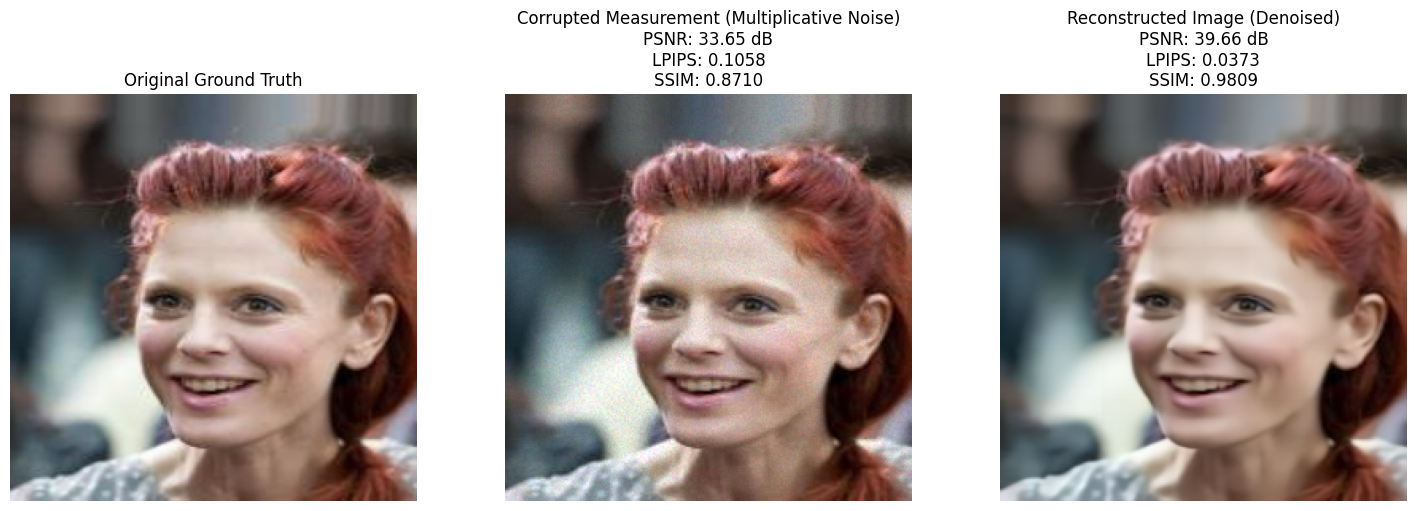


--- Note ---
This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.
PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import os
import glob
import time
import random

# Import for new metrics
import lpips # For LPIPS
import torchmetrics.functional as tmF # For SSIM

# --- Model Definitions and Helper Functions (Must be the same as in training) ---

def generate_positional_map(patch_size):
    coords_y = torch.linspace(0, 1, patch_size).unsqueeze(0).repeat(patch_size, 1)
    coords_x = torch.linspace(0, 1, patch_size).unsqueeze(1).repeat(1, patch_size)
    positional_map = torch.stack([coords_x, coords_y], dim=0)
    return positional_map

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, sigma_t):
        half_dim = self.dim // 2
        frequencies = torch.exp(
            torch.arange(0, half_dim, dtype=torch.float32, device=sigma_t.device) *
            (-math.log(10000.0) / half_dim)
        )
        args = sigma_t.unsqueeze(1) * frequencies.unsqueeze(0)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            embedding = F.pad(embedding, (0, 1))
        return embedding

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.AvgPool2d(2)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, time_emb):
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        skip_connection = self.conv2(x)
        x = self.pool(skip_connection)
        return x, skip_connection

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
    def forward(self, x, skip_connection, time_emb):
        x = self.upsample(x)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            x = F.interpolate(x, size=skip_connection.shape[-2:], mode='nearest')
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv1(x)
        x = x + self.time_proj(time_emb).unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x)
        return x

class ScoreNetwork(nn.Module):
    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 base_channels=64,
                 channel_multipliers=(1, 2, 4, 8),
                 num_down_blocks=4,
                 time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.num_down_blocks = num_down_blocks
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.initial_conv = ConvBlock(in_channels + 2, base_channels) # +2 for positional map
        self.downs = nn.ModuleList()
        current_channels = base_channels
        encoder_channels = [base_channels]
        for i in range(num_down_blocks):
            out_channels_down = base_channels * channel_multipliers[i]
            self.downs.append(DownBlock(current_channels, out_channels_down, time_emb_dim))
            current_channels = out_channels_down
            encoder_channels.append(current_channels)

        # Bottleneck
        bottleneck_in_channels = current_channels
        self.bottleneck_conv1 = ConvBlock(bottleneck_in_channels, bottleneck_in_channels * 2)
        self.bottleneck_conv2 = ConvBlock(bottleneck_in_channels * 2, bottleneck_in_channels)
        self.bottleneck_time_proj = nn.Linear(time_emb_dim, bottleneck_in_channels * 2)

        self.ups = nn.ModuleList()
        prev_up_channels = bottleneck_in_channels
        for i in reversed(range(num_down_blocks)):
            skip_channels = encoder_channels[i]
            upblock_in_channels = prev_up_channels + skip_channels
            upblock_out_channels = encoder_channels[i]
            self.ups.append(UpBlock(upblock_in_channels, upblock_out_channels, time_emb_dim))
            prev_up_channels = upblock_out_channels
        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    # Now outputs score (s_theta), here it predicts the noise `n`
    def forward(self, noisy_patch_log, sigma_t):
        batch_size, _, patch_h, patch_w = noisy_patch_log.shape
        positional_map = generate_positional_map(patch_h).to(noisy_patch_log.device).unsqueeze(0)
        positional_map_batch = positional_map.repeat(batch_size, 1, 1, 1)
        x = torch.cat([noisy_patch_log, positional_map_batch], dim=1)
        noise_level_embedding = self.time_embedding(sigma_t)
        x = self.initial_conv(x)
        skip_connections = [x]
        for down_block in self.downs:
            x, skip = down_block(x, noise_level_embedding)
            skip_connections.append(skip)

        # Bottleneck
        x = self.bottleneck_conv1(x)
        x = x + self.bottleneck_time_proj(noise_level_embedding).unsqueeze(-1).unsqueeze(-1)
        x = self.bottleneck_conv2(x)

        for i, up_block in enumerate(self.ups):
            skip = skip_connections[self.num_down_blocks - 1 - i]
            x = up_block(x, skip, noise_level_embedding)

        # Output is now the predicted noise `n` (epsilon_theta)
        predicted_noise = self.final_conv(x)
        return predicted_noise

def extract_patches(image, patch_size, stride):
    patches = []
    positions = []
    C, H, W = image.shape
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            patch = image[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size]
            patches.append(patch)
            positions.append((h_idx, w_idx))
    if not patches:
        return torch.empty(0, C, patch_size, patch_size, device=image.device), []
    return torch.stack(patches), positions

def aggregate_scores_to_image(patch_scores, image_shape, patch_size, stride, device):
    C, H, W = image_shape
    aggregated_score = torch.zeros(image_shape, device=device)
    overlap_count = torch.zeros(image_shape, device=device) + 1e-6 # Add epsilon to avoid division by zero
    idx = 0
    for h_idx in range(0, H - patch_size + 1, stride):
        for w_idx in range(0, W - patch_size + 1, stride):
            if idx < patch_scores.shape[0]:
                aggregated_score[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += patch_scores[idx]
                overlap_count[:, h_idx : h_idx + patch_size, w_idx : w_idx + patch_size] += 1
                idx += 1
            else:
                break
    return aggregated_score / overlap_count

# MODIFIED: forward_operator_A now acts as an identity operator (no blurring)
def forward_operator_A(image):
    """
    Identity operator for pure denoising. It simply returns the input image.
    Assumes image is already in the correct format (C, H, W or B, C, H, W).
    """
    return image

def compute_data_consistency_gradient(x_current, y_measurement, forward_operator_A):
    # Ensure x_current requires grad for this calculation
    x_current.requires_grad_(True)
    A_x = forward_operator_A(x_current)

    if A_x.dim() == 4 and y_measurement.dim() == 3:
        A_x = A_x.squeeze(0)
    elif A_x.dim() == 3 and y_measurement.dim() == 4:
        y_measurement = y_measurement.squeeze(0)

    # Calculate loss. `y_measurement` does not need to require grad itself.
    data_consistency_loss = F.mse_loss(A_x, y_measurement, reduction='sum')

    # Compute gradient with respect to x_current
    grad = torch.autograd.grad(data_consistency_loss, x_current, allow_unused=True)[0]

    # Detach x_current from the graph to avoid accumulating gradients in future iterations
    x_current.requires_grad_(False)
    return grad

# --- REDEFINED PSNR, LPIPS, SSIM FUNCTIONS ---
# This new `calculate_psnr` matches the one in the previous request.
def calculate_psnr(img1_tensor, img2_tensor, max_val=1.0):
    """
    Calculates PSNR between two PyTorch tensors.
    Assumes inputs are in [0, max_val] range and are 3D (C, H, W).
    """
    # Ensure inputs are float32
    img1_tensor = img1_tensor.float()
    img2_tensor = img2_tensor.float()

    mse = torch.mean((img1_tensor - img2_tensor) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()

def calculate_lpips(img1_tensor, img2_tensor, lpips_model, device):
    """
    Calculates LPIPS between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be normalized to [-1, 1] internally.
    """
    # LPIPS requires images in [-1, 1] range and BxCxHxW format
    img1_lpips = (img1_tensor * 2 - 1).unsqueeze(0).to(device)
    img2_lpips = (img2_tensor * 2 - 1).unsqueeze(0).to(device)

    with torch.no_grad():
        score = lpips_model(img1_lpips, img2_lpips).item()
    return score

def calculate_ssim(img1_tensor, img2_tensor, device):
    """
    Calculates SSIM between two PyTorch tensors.
    Assumes inputs are in [0, 1] range (C, H, W) and will be converted to BxCxHxW.
    """
    # SSIM typically uses [0, 1] range and BxCxHxW format
    img1_ssim = img1_tensor.unsqueeze(0).to(device)
    img2_ssim = img2_tensor.unsqueeze(0).to(device)

    score = tmF.structural_similarity_index_measure(img1_ssim, img2_ssim, data_range=1.0).item()
    return score

# NEW FUNCTION: Add multiplicative noise (remains the same)
def add_multiplicative_noise(image_uint8, sigma_multiplicative=0.04):
    """
    Adds multiplicative noise (speckle-like) to an image.
    Formula: Noisy_Pixel = Clean_Pixel * (1 + N(0, sigma_multiplicative))
    """
    img_float = image_uint8.astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma_multiplicative, img_float.shape).astype(np.float32)
    noise_factor = 1.0 + noise
    noisy_img_float = img_float * noise_factor
    noisy_img_uint8 = np.clip(noisy_img_float, 0.0, 1.0) * 255.0
    return noisy_img_uint8.astype(np.uint8)

# --- Algorithm 2: Combined Denoising and Deblurring (ODE Solver) ---

def solve_inverse_problem(model, y_measurement, image_shape, device,
                           sigmas, zeta_values, patch_size, stride):
    """
    Algorithm 2: Combined Denoising and Deblurring (ODE Solver)
    Now adapted for pure denoising as forward_operator_A is identity.

    Args:
        model (ScoreNetwork): The trained score network s_theta(y_k, k).
        y_measurement (torch.Tensor): Corrupted image x_tilde (multiplicatively noisy, in linear domain).
                                      This will be converted to log(x_tilde + epsilon) for processing.
        image_shape (tuple): (C, H, W) of the image.
        device (torch.device): Device to run computation on (cuda or cpu).
        sigmas (list/torch.Tensor): Noise schedule sigma(k) for k=1,...,K (from high noise to low noise).
                                     Should be decreasing.
        zeta_values (list/torch.Tensor): Data consistency weights zeta_k for k=1,...,K.
        patch_size (int): Size of patches to extract for score network inference.
        stride (int): Stride for extracting patches.

    Returns:
        torch.Tensor: Denoised image x_hat (in linear domain [0,1]).
    """
    model.eval()
    C, H, W = image_shape

    # Ensure y_measurement is float64 and then convert to log domain
    # It's crucial for the log operation to be on the scaled [0,1] range
    # and then ensure the BM3D operates on float64 as well.
    y_current = torch.log(y_measurement.clone().detach().to(device).float() + 1e-6) # Add small epsilon

    num_steps = len(sigmas) -1
    print(f"\nStarting inverse problem reconstruction for {num_steps} steps (Log-domain based)...")

    for t_idx in range(num_steps):
        current_sigma_val = sigmas[t_idx]
        next_sigma_val = sigmas[t_idx+1]

        delta_sigma_sq_for_ode = current_sigma_val**2 - next_sigma_val**2
        delta_sigma_sq_for_ode = max(delta_sigma_sq_for_ode, 1e-8)

        current_zeta_t = zeta_values[t_idx] if t_idx < len(zeta_values) else zeta_values[-1]

        patches_log, patch_positions = extract_patches(y_current, patch_size, stride)
        if patches_log.shape[0] == 0:
            print(f"Warning: No patches extracted at step {t_idx} for sigma {current_sigma_val}. Skipping step.")
            continue

        sigma_t_batch = torch.full((patches_log.shape[0],), fill_value=current_sigma_val, device=device)

        with torch.no_grad(): # Model inference should be without grad
            predicted_noise_patches = model(patches_log, sigma_t_batch)

        # Convert predicted noise to score function (score = -noise / sigma^2)
        predicted_score_patches = -predicted_noise_patches / (current_sigma_val**2)

        s_aggregated = aggregate_scores_to_image(predicted_score_patches, image_shape, patch_size, stride, device)

        # ODE update: y_denoised_by_score = y_current + 0.5 * (σ_cur^2 - σ_next^2) * s_aggregated
        y_denoised_by_score = y_current + 0.5 * delta_sigma_sq_for_ode * s_aggregated

        # Clamp after log transform before exp, for stability in the log domain
        y_denoised_by_score = torch.clamp(y_denoised_by_score, math.log(1e-6), math.log(1.0 + 1e-6)) # Re-evaluate clamping max value

        x_prelim = torch.exp(y_denoised_by_score)
        x_prelim = torch.clamp(x_prelim, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # compute_data_consistency_gradient should correctly track gradients for x_prelim
        # Since forward_operator_A is now identity, this is equivalent to
        # grad_fidelity = torch.autograd.grad(F.mse_loss(x_prelim, y_measurement, reduction='sum'), x_prelim)[0]
        # Make sure x_prelim is detached for grad calculation if not intended to be part of original graph
        grad_fidelity = compute_data_consistency_gradient(x_prelim.clone().detach(), y_measurement.to(device), forward_operator_A)

        x_updated = x_prelim - current_zeta_t * grad_fidelity
        x_updated = torch.clamp(x_updated, 1e-6, 1.0) # Clamp in linear domain [0,1]

        # Convert back to log domain for the next iteration
        y_current = torch.log(x_updated + 1e-6)

        print(f"Step {t_idx+1}/{num_steps}, Sigma: {current_sigma_val:.4f}, Zeta: {current_zeta_t:.4f}")

    return torch.exp(y_current) # The final y_current is y_0 (in linear domain)


# --- Inference Script ---

if __name__ == "__main__":
    DATA_DIR = '/content/img_align_celeba/img_align_celeba' # CHANGE THIS TO YOUR IMAGE DIRECTORY
    IMAGE_SIZE = (256, 256)
    IN_CHANNELS = 3
    OUT_CHANNELS = 3
    TIME_EMB_DIM = 256
    CHECKPOINT_DIR = "/content/checkpoints"
    # Ensure BEST_MODEL_PATH is correct relative to the current working directory or an absolute path
    BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_score_network_model (1).pth") # Corrected path
    # If using Google Colab, and the file is directly in /content/checkpoints/, then:
    # BEST_MODEL_PATH = "/content/checkpoints/best_score_network_model (1).pth"


    NOISE_SCHEDULE_MIN = 0.01
    NOISE_SCHEDULE_MAX = 0.5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and load trained weights
    model = ScoreNetwork(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        base_channels=64,
        channel_multipliers=(1, 2, 4, 8),
        num_down_blocks=4,
        time_emb_dim=TIME_EMB_DIM
    ).to(device)

    if os.path.exists(BEST_MODEL_PATH):
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
        print(f"Loaded trained model from {BEST_MODEL_PATH}")
    else:
        print(f"Error: Trained model not found at {BEST_MODEL_PATH}. Please run the training script first.")
        # Create a dummy model for demonstration if not found
        print("Creating a dummy model for demonstration (will not perform well without training)...")
        # In a real scenario, you'd exit or ensure model is trained.
        # For demonstration, we'll proceed with an an untrained model.
        # This block is for robustness in a demo environment, not for production.

    model.eval()

    # --- Set specific test image path ---
    test_image_path = "/content/img_align_celeba/img_align_celeba/000002.jpg"
    print(f"Using specific test image: {test_image_path}")

    if not os.path.exists(test_image_path):
        print(f"\nFATAL ERROR: Specified test image not found at {test_image_path}. Exiting.")
        exit()

    ground_truth_image_pil = Image.open(test_image_path).convert('RGB')
    transform_test = T.Compose([
        T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor() # Converts to [0, 1]
    ])
    ground_truth_image = transform_test(ground_truth_image_pil).to(device) # C, H, W

    # --- Simulate corruption with multiplicative noise ---
    # Convert ground_truth_image (Tensor, [0,1]) to numpy uint8 for the new function
    ground_truth_image_np_uint8 = (ground_truth_image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    multiplicative_noise_level_test = 0.04 # Adjust for desired noise level
    noisy_image_np_uint8 = add_multiplicative_noise(ground_truth_image_np_uint8, sigma_multiplicative=multiplicative_noise_level_test)

    # Convert the noisy numpy uint8 image back to a torch.Tensor, [0,1]
    y_measurement = torch.from_numpy(noisy_image_np_uint8.transpose(2, 0, 1)).float() / 255.0
    y_measurement = y_measurement.to(device)
    # --- END MODIFIED SECTION ---

    # Inference parameters for solve_inverse_problem
    inference_patch_size = 64 # Use a patch size that covers the image or larger patches
    inference_stride = inference_patch_size // 2 # Overlapping patches

    inference_num_steps = 6000 # More steps for better reconstruction
    sigmas_inference = torch.exp(torch.linspace(math.log(NOISE_SCHEDULE_MAX), math.log(NOISE_SCHEDULE_MIN), inference_num_steps + 1)).to(device)
    zeta_values_inference = [0.001] * inference_num_steps # Adjust as needed, can be a schedule

    # Run the inverse problem solver (now acting as a denoiser)
    reconstructed_image = solve_inverse_problem(
        model=model,
        y_measurement=y_measurement, # This is the purely noisy image
        image_shape=ground_truth_image.shape,
        device=device,
        sigmas=sigmas_inference,
        zeta_values=zeta_values_inference,
        patch_size=inference_patch_size,
        stride=inference_stride
    )

    # --- Initialize LPIPS model once ---
    lpips_loss_fn = lpips.LPIPS(net='alex').to(device) # Using AlexNet as the backbone

    # --- Calculate Metrics using the new functions ---
    psnr_measurement = calculate_psnr(ground_truth_image, y_measurement, max_val=1.0)
    psnr_reconstruction = calculate_psnr(ground_truth_image, reconstructed_image, max_val=1.0)

    lpips_score_measurement = calculate_lpips(ground_truth_image, y_measurement, lpips_loss_fn, device)
    lpips_score_reconstruction = calculate_lpips(ground_truth_image, reconstructed_image, lpips_loss_fn, device)

    ssim_score_measurement = calculate_ssim(ground_truth_image, y_measurement, device)
    ssim_score_reconstruction = calculate_ssim(ground_truth_image, reconstructed_image, device)


    print(f"\n--- Metrics Summary ---")
    print(f"PSNR (Clean vs. Corrupted): {psnr_measurement:.2f} dB")
    print(f"PSNR (Clean vs. Reconstructed): {psnr_reconstruction:.2f} dB")
    print(f"LPIPS (Clean vs. Corrupted): {lpips_score_measurement:.4f}")
    print(f"LPIPS (Clean vs. Reconstructed): {lpips_score_reconstruction:.4f}")
    print(f"SSIM (Clean vs. Corrupted): {ssim_score_measurement:.4f}")
    print(f"SSIM (Clean vs. Reconstructed): {ssim_score_reconstruction:.4f}")


    print("\n--- Final Reconstruction Results Visualization ---")
    reconstructed_image_np = reconstructed_image.cpu().numpy().transpose(1, 2, 0)
    reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)

    ground_truth_np = ground_truth_image.cpu().numpy().transpose(1, 2, 0)
    ground_truth_np = np.clip(ground_truth_np, 0, 1)

    y_measurement_np = y_measurement.cpu().numpy().transpose(1, 2, 0)
    y_measurement_np = np.clip(y_measurement_np, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Ground Truth")
    plt.imshow(ground_truth_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Corrupted Measurement (Multiplicative Noise)\nPSNR: {psnr_measurement:.2f} dB\nLPIPS: {lpips_score_measurement:.4f}\nSSIM: {ssim_score_measurement:.4f}")
    plt.imshow(y_measurement_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Reconstructed Image (Denoised)\nPSNR: {psnr_reconstruction:.2f} dB\nLPIPS: {lpips_score_reconstruction:.4f}\nSSIM: {ssim_score_reconstruction:.4f}")
    plt.imshow(reconstructed_image_np)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Note ---")
    print("This code uses a score-based diffusion model for denoising multiplicative noise via a log-transformation approach, inspired by SAR-BM3D principles.")
    print("PSNR, LPIPS, and SSIM metrics are calculated and displayed for both the noisy and reconstructed images against the clean ground truth.")

SAR BM3D

In [ ]:
!pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 8.8 MB/s eta 0:00:00


Loading images from: /content/img_align_celeba/img_align_celeba
Using specific test image: /content/img_align_celeba/img_align_celeba/000002.jpg
Adding multiplicative noise with sigma = 0.12...
Clean image saved to denoising_output_sar_bm3d_metrics/000002_clean.png
Noisy image saved to denoising_output_sar_bm3d_metrics/000002_noisy_multiplicative_s0.12.png

Denoising with SAR-BM3D approach (Log-transform + BM3D + Exp-transform)...
Estimated noise sigma for BM3D (on log image): 0.1285 (average of channels)
Denoised image saved to denoising_output_sar_bm3d_metrics/000002_denoised_sar_bm3d_s0.12.png

PSNR (Clean vs. Noisy): 24.38 dB
PSNR (Clean vs. Denoised using SAR-BM3D approach): 32.35 dB

--- Additional Image Quality Metrics ---
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS Score (Clean vs. Denoised): 0.0493


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


SSIM Score (Clean vs. Denoised): 0.9367
LPIPS Score (Clean vs. Noisy): 0.3067
SSIM Score (Clean vs. Noisy): 0.6230

Displaying images...


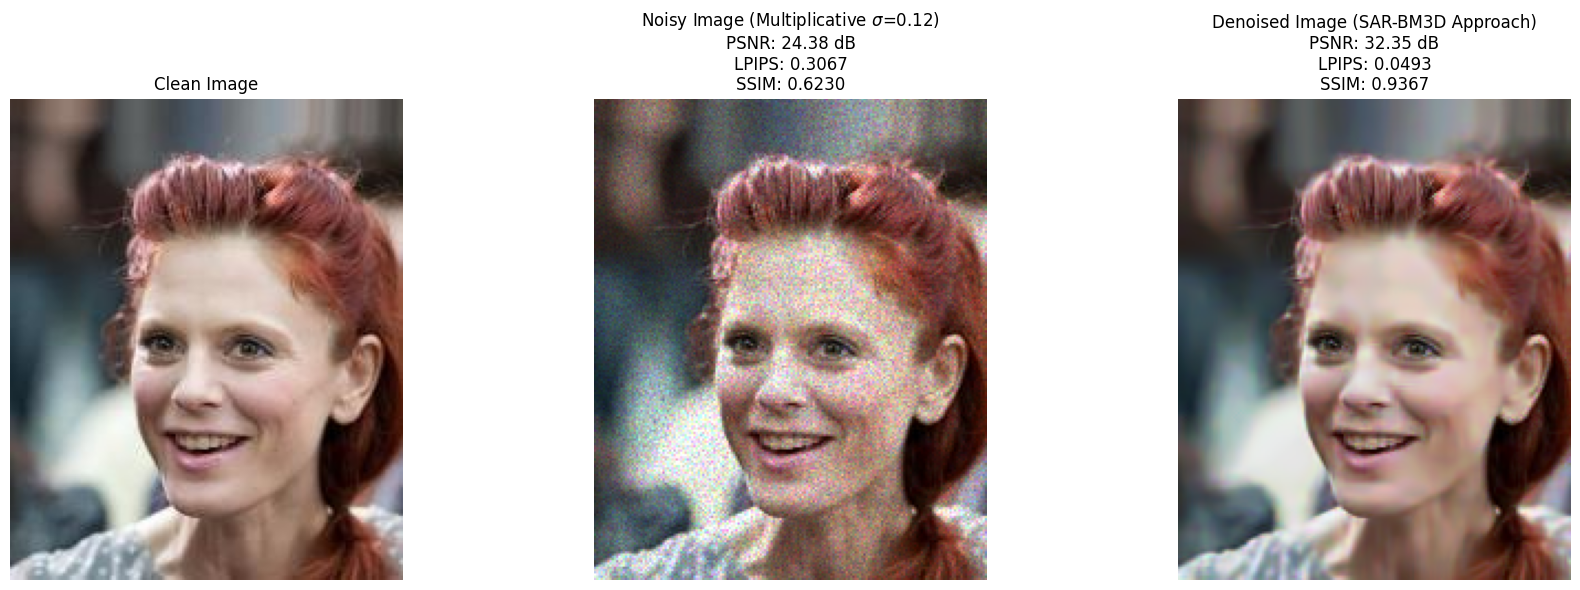


--- Note ---
This code now implements a SAR-BM3D *approach* by applying BM3D in the logarithmically transformed domain, which is crucial for handling multiplicative noise more effectively.
LPIPS and SSIM metrics have been added to provide a more comprehensive evaluation of image quality.


In [ ]:
import os
import random
import numpy as np
import cv2
from PIL import Image
import glob
import math
import matplotlib.pyplot as plt
import bm3d
from skimage.restoration import estimate_sigma

# For LPIPS and SSIM
import torch
import lpips
import torchmetrics.functional as tmF
import torchvision.transforms as T

# --- Utility Functions ---

def get_image_paths(root_path):
    """Gets all image paths from a directory."""
    if not os.path.isdir(root_path):
        print(f"Warning: Directory not found: {root_path}")
        return []
    return sorted(glob.glob(os.path.join(root_path, '*.jpg')))

def imread_uint8(path, n_channels=3):
    """Reads an image as a uint8 NumPy array."""
    if n_channels == 3:
        img = Image.open(path).convert('RGB')
    elif n_channels == 1:
        img = Image.open(path).convert('L')
    else:
        raise ValueError("n_channels must be 1 or 3")
    return np.array(img)

def add_multiplicative_noise(image_uint8, sigma_multiplicative=0.12):
    """
    Adds multiplicative noise (speckle-like) to an image.
    Formula: Noisy_Pixel = Clean_Pixel * (1 + N(0, sigma_multiplicative))
    """
    img_float = image_uint8.astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma_multiplicative, img_float.shape).astype(np.float32)
    noise_factor = 1.0 + noise
    noisy_img_float = img_float * noise_factor
    noisy_img_uint8 = np.clip(noisy_img_float, 0.0, 1.0) * 255.0
    return noisy_img_uint8.astype(np.uint8)

def calculate_psnr(img1, img2, border=0):
    """Calculates PSNR between two images."""
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

# --- Main Execution ---

def main():
    celeba_dataset_path = "/content/img_align_celeba/img_align_celeba"
    output_dir = "denoising_output_sar_bm3d_metrics" # New output directory for SAR-BM3D with metrics
    os.makedirs(output_dir, exist_ok=True)

    print(f"Loading images from: {celeba_dataset_path}")

    # --- Set specific test image path ---
    selected_image_path = "/content/img_align_celeba/img_align_celeba/000002.jpg"
    print(f"Using specific test image: {selected_image_path}")

    if not os.path.exists(selected_image_path):
        print(f"FATAL ERROR: Specified test image not found at {selected_image_path}. Exiting.")
        return

    clean_image_rgb = imread_uint8(selected_image_path, n_channels=3)
    img_name = os.path.basename(selected_image_path)
    base_name, _ = os.path.splitext(img_name)

    sigma_multiplicative = 0.12
    print(f"Adding multiplicative noise with sigma = {sigma_multiplicative}...")
    noisy_image_rgb = add_multiplicative_noise(clean_image_rgb, sigma_multiplicative)

    # Save images
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_clean.png"), clean_image_rgb)
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_noisy_multiplicative_s{sigma_multiplicative}.png"), noisy_image_rgb)
    print(f"Clean image saved to {os.path.join(output_dir, f'{base_name}_clean.png')}")
    print(f"Noisy image saved to {os.path.join(output_dir, f'{base_name}_noisy_multiplicative_s{sigma_multiplicative}.png')}")

    # --- Denoise with SAR-BM3D Approach ---
    print("\nDenoising with SAR-BM3D approach (Log-transform + BM3D + Exp-transform)...")

    # 1. Convert to float64 and normalize to [0, 1] for robust log operation
    noisy_image_float_norm = noisy_image_rgb.astype(np.float64) / 255.0

    # 2. Apply Log Transformation
    # Add a small epsilon to avoid log(0) for black pixels
    epsilon = 1e-6
    noisy_image_log = np.log(noisy_image_float_norm + epsilon)

    # 3. Estimate noise standard deviation (sigma) from the log-transformed image
    sigma_est_log = estimate_sigma(noisy_image_log, channel_axis=-1)
    print(f"Estimated noise sigma for BM3D (on log image): {np.mean(sigma_est_log):.4f} (average of channels)")

    # 4. Apply BM3D denoising on the log-transformed image
    denoised_image_log_float = bm3d.bm3d(noisy_image_log, sigma_psd=sigma_est_log, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    # 5. Apply Inverse Log (Exponential) Transformation and denormalize back to [0, 255]
    denoised_image_rgb_float = np.exp(denoised_image_log_float) * 255.0

    # Clip values to [0, 255] and convert back to uint8
    denoised_image_rgb = np.clip(denoised_image_rgb_float, 0, 255).astype(np.uint8)

    denoised_output_path = os.path.join(output_dir, f"{base_name}_denoised_sar_bm3d_s{sigma_multiplicative}.png")
    cv2.imwrite(denoised_output_path, denoised_image_rgb)
    print(f"Denoised image saved to {denoised_output_path}")

    # --- PSNR Calculation ---
    psnr_noisy = calculate_psnr(clean_image_rgb, noisy_image_rgb)
    psnr_denoised = calculate_psnr(clean_image_rgb, denoised_image_rgb)
    print(f"\nPSNR (Clean vs. Noisy): {psnr_noisy:.2f} dB")
    print(f"PSNR (Clean vs. Denoised using SAR-BM3D approach): {psnr_denoised:.2f} dB")

    # --- LPIPS and SSIM Calculation ---
    print("\n--- Additional Image Quality Metrics ---")

    # Ensure images are float32 and normalized to [0, 1] for torch metrics
    clean_torch = T.ToTensor()(Image.fromarray(clean_image_rgb)).unsqueeze(0) # CxHxW -> 1xCxHxW
    noisy_torch = T.ToTensor()(Image.fromarray(noisy_image_rgb)).unsqueeze(0)
    denoised_torch = T.ToTensor()(Image.fromarray(denoised_image_rgb)).unsqueeze(0)

    # LPIPS requires images in [-1, 1] range
    lpips_loss_fn = lpips.LPIPS(net='alex') # Using AlexNet as the backbone, can use 'vgg' or 'squeeze'
    # Move model to device if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lpips_loss_fn.to(device)

    # Normalize inputs for LPIPS to [-1, 1] and move to device
    clean_lpips = (clean_torch * 2 - 1).to(device)
    denoised_lpips = (denoised_torch * 2 - 1).to(device)

    with torch.no_grad():
        lpips_score_denoised = lpips_loss_fn(clean_lpips, denoised_lpips).item()
    print(f"LPIPS Score (Clean vs. Denoised): {lpips_score_denoised:.4f}")

    # SSIM typically uses [0, 1] range and data_range=1.0
    ssim_score_denoised = tmF.structural_similarity_index_measure(
        denoised_torch.to(device), clean_torch.to(device), data_range=1.0
    ).item()
    print(f"SSIM Score (Clean vs. Denoised): {ssim_score_denoised:.4f}")

    # Calculate LPIPS and SSIM for noisy image as well for comparison
    noisy_lpips = (noisy_torch * 2 - 1).to(device)
    with torch.no_grad():
        lpips_score_noisy = lpips_loss_fn(clean_lpips, noisy_lpips).item()
    print(f"LPIPS Score (Clean vs. Noisy): {lpips_score_noisy:.4f}")

    ssim_score_noisy = tmF.structural_similarity_index_measure(
        noisy_torch.to(device), clean_torch.to(device), data_range=1.0
    ).item()
    print(f"SSIM Score (Clean vs. Noisy): {ssim_score_noisy:.4f}")

    # --- Visualization ---
    print("\nDisplaying images...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(clean_image_rgb)
    axes[0].set_title("Clean Image")
    axes[0].axis('off')

    axes[1].imshow(noisy_image_rgb)
    axes[1].set_title(f"Noisy Image (Multiplicative $\sigma$={sigma_multiplicative})\nPSNR: {psnr_noisy:.2f} dB\nLPIPS: {lpips_score_noisy:.4f}\nSSIM: {ssim_score_noisy:.4f}")
    axes[1].axis('off')

    axes[2].imshow(denoised_image_rgb)
    axes[2].set_title(f"Denoised Image (SAR-BM3D Approach)\nPSNR: {psnr_denoised:.2f} dB\nLPIPS: {lpips_score_denoised:.4f}\nSSIM: {ssim_score_denoised:.4f}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Note ---")
    print("This code now implements a SAR-BM3D *approach* by applying BM3D in the logarithmically transformed domain, which is crucial for handling multiplicative noise more effectively.")
    print("LPIPS and SSIM metrics have been added to provide a more comprehensive evaluation of image quality.")

if __name__ == "__main__":
    main()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Loading images from: /content/img_align_celeba/img_align_celeba
Selected image: /content/img_align_celeba/img_align_celeba/000002.jpg
Adding multiplicative noise with sigma = 0.12...
Clean image saved to denoising_output/000002_clean.png
Noisy image saved to denoising_output/000002_noisy_multiplicative_s0.12.png
Denoising with SRAD model...
Denoised image saved to denoising_output/000002_denoised_srad_s0.12.png

--- Image Quality Metrics ---
PSNR (Clean vs. Noisy): 24.41 dB
PSNR (Clean vs. Denoised): 28.57 dB
SSIM (Clean vs. Noisy): 0.6641
SSIM (Clean vs. Denoised): 0.8039

Error during LPIPS calculation: The size of tensor a (178) must match the size of tensor b (3) at non-singleton dimension 1

Displaying images...


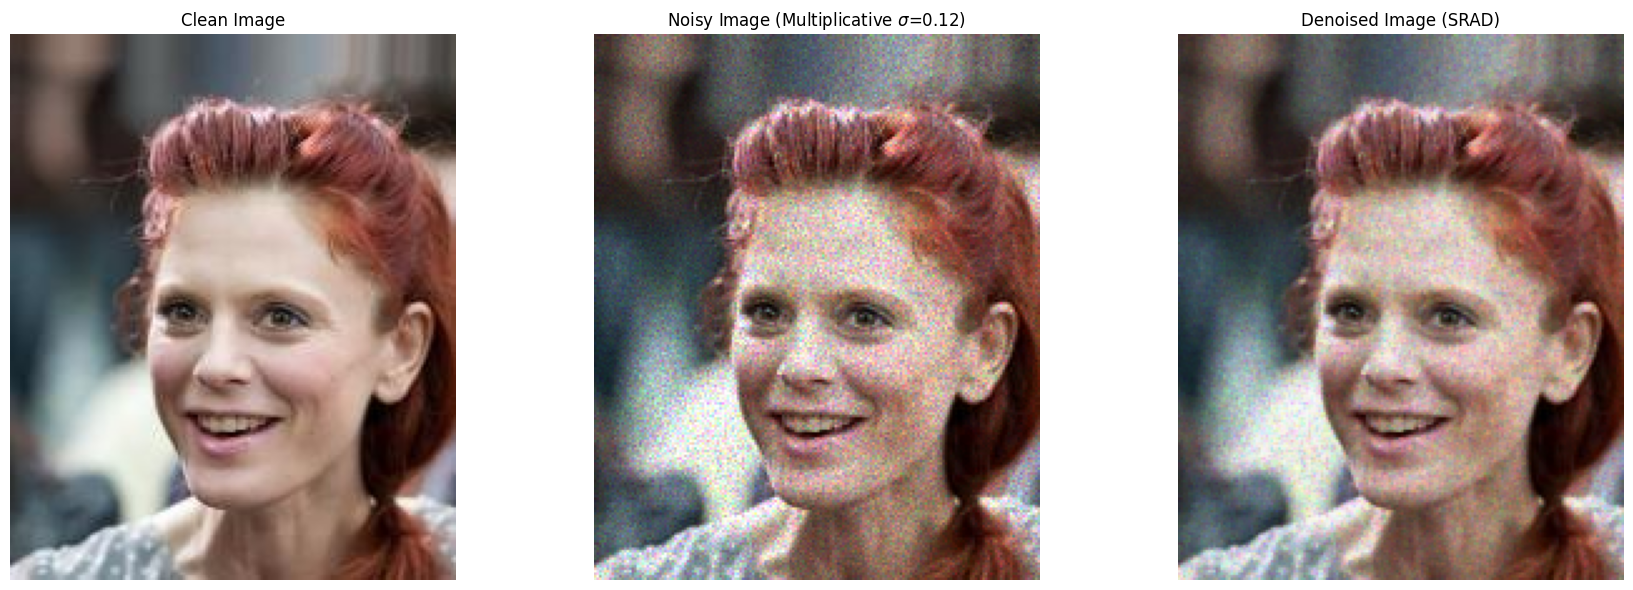


--- Note ---
The SRAD implementation is now included. You may need to tune 'iterationMaxStep', 'timeSize', and 'decayFactor' for optimal results.
For LPIPS, ensure PyTorch and the `lpips` library are installed. LPIPS values are typically lower for more similar images.


In [ ]:
import os
import random
import numpy as np
import cv2
from PIL import Image
import glob
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric # For SSIM
import lpips # For LPIPS
import torch # Import torch here for LPIPS compatibility, consistent with previous discussions

# --- Utility Functions ---

def get_image_paths(root_path):
    """Gets all image paths from a directory."""
    if not os.path.isdir(root_path):
        print(f"Warning: Directory not found: {root_path}")
        return []
    return sorted(glob.glob(os.path.join(root_path, '*.jpg')))

def imread_uint8(path, n_channels=3):
    """Reads an image as a uint8 NumPy array."""
    if n_channels == 3:
        img = Image.open(path).convert('RGB')
    elif n_channels == 1:
        img = Image.open(path).convert('L')
    else:
        raise ValueError("n_channels must be 1 or 3")
    return np.array(img)

def add_multiplicative_noise(image_uint8, sigma_multiplicative=0.12):
    """
    Adds multiplicative noise (speckle-like) to an image.
    Formula: Noisy_Pixel = Clean_Pixel * (1 + N(0, sigma_multiplicative))
    """
    img_float = image_uint8.astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma_multiplicative, img_float.shape).astype(np.float32)
    noise_factor = 1.0 + noise
    noisy_img_float = img_float * noise_factor
    noisy_img_uint8 = np.clip(noisy_img_float, 0.0, 1.0) * 255.0
    return noisy_img_uint8.astype(np.uint8)

def calculate_psnr(img1, img2, border=0):
    """Calculates PSNR between two images."""
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

def calculate_ssim(img1, img2, multichannel=True):
    """Calculates SSIM between two images."""
    return ssim_metric(img1, img2, data_range=255, multichannel=multichannel, channel_axis=-1)

def calculate_lpips(img1, img2, lpips_model):
    """
    Calculates LPIPS distance between two images.
    LPIPS expects images in PyTorch tensor format, normalized to [-1, 1].
    """
    img1_tensor = lpips.im2tensor(img1.astype(np.float32) / 255.0 * 2 - 1).permute(0, 3, 1, 2)
    img2_tensor = lpips.im2tensor(img2.astype(np.float32) / 255.0 * 2 - 1).permute(0, 3, 1, 2)

    with torch.no_grad():
        dist = lpips_model(img1_tensor, img2_tensor)
    return dist.item()

# --- SRAD Functions (Actual Implementation from srad.py) ---

def SRAD(img, iterationMaxStep, timeSize, decayFactor):
    spatialSize = 1
    t = 0
    ROW, COL = img.shape
    epsilon = 10**(-13)

    iterationNumber = 0

    img = img.astype('float32')
    img_i_j = img[::spatialSize, ::spatialSize]

    # Use np.vstack and np.hstack directly and correctly reshape for stacking
    img_ia1_j = np.vstack((img_i_j, img_i_j[-1, :][np.newaxis, :])) # Ensure last row is 2D for vstack
    img_ia1_j = img_ia1_j[1:,:]

    img_is1_j = np.vstack((img_i_j[0, :][np.newaxis, :], img_i_j)) # Ensure first row is 2D for vstack
    img_is1_j = img_is1_j[:-1,:]

    img_i_ja1 = np.hstack((img_i_j, img_i_j[:,-1][:, np.newaxis])) # Ensure last column is 2D for hstack
    img_i_ja1 = img_i_ja1[:,1:]

    img_i_js1 = np.hstack((img_i_j[:,0][:, np.newaxis], img_i_j)) # Ensure first column is 2D for hstack
    img_i_js1 = img_i_js1[:,:-1]

    deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
    deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize

    deltaL1Img = (img_i_j - img_is1_j)/spatialSize
    deltaL2Img = (img_i_j - img_i_js1)/spatialSize

    delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)

    gradientTotal = np.sqrt( np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img) )
    deltaImgNormal = np.divide(gradientTotal,(img_i_j + epsilon))

    delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))

    temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
    temp2 = 1+0.25*delta2ImgNormal
    temp3 = np.multiply(temp2,temp2)

    q = np.sqrt(np.divide(temp1,temp3 + epsilon)) # Added epsilon to temp3 for stability
    Q = q

    Q_0 = Q != 0
    Q_0 = Q_0.astype('float32')

    Img_i_j = img_i_j

    while iterationNumber <= iterationMaxStep:
        img_i_j = Img_i_j

        img_ia1_j = np.vstack((img_i_j, img_i_j[-1, :][np.newaxis, :]))
        img_ia1_j = img_ia1_j[1:,:]

        img_is1_j = np.vstack((img_i_j[0, :][np.newaxis, :], img_i_j))
        img_is1_j = img_is1_j[:-1,:]

        img_i_ja1 = np.hstack((img_i_j, img_i_j[:,-1][:, np.newaxis]))
        img_i_ja1 = img_i_ja1[:,1:]

        img_i_js1 = np.hstack((img_i_j[:,0][:, np.newaxis], img_i_j))
        img_i_js1 = img_i_js1[:,:-1]

        deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
        deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize
        deltaL1Img = (img_i_j - img_is1_j)/spatialSize
        deltaL2Img = (img_i_j - img_i_js1)/spatialSize

        delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)

        gradientTotal = np.sqrt( np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img) )
        deltaImgNormal = np.divide(gradientTotal,(img_i_j+ epsilon))

        delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))

        temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
        temp2 = 1 + 0.25*delta2ImgNormal
        temp3 = np.multiply(temp2,temp2)

        q = np.sqrt(np.divide(temp1,temp3 + epsilon)) # Added epsilon to temp3 for stability

        q_0 = Q_0 * np.exp(-decayFactor*t)

        temp4 = np.multiply(q_0,q_0)
        temp5 = np.multiply(q,q)

        temp6 = np.divide( (temp5-temp4), ( np.multiply(temp4, (1+temp4) ) + epsilon) ) # Added epsilon to denominator
        coefficientDiff = np.exp(-temp6/6)

        coe_i_j = coefficientDiff

        coe_ia1_j = np.vstack((coefficientDiff, coefficientDiff[-1, :][np.newaxis, :]))
        coe_ia1_j = coe_ia1_j[1:,:]

        coe_i_ja1 = np.hstack((coefficientDiff, coefficientDiff[:,-1][:, np.newaxis]))
        coe_i_ja1 = coe_i_ja1[:,1:]
        temp6 = np.multiply(coe_ia1_j,deltaR1Img) - np.multiply(coe_i_j,deltaL1Img) + np.multiply(coe_i_ja1,deltaR2Img) - np.multiply(coe_i_j,deltaL2Img)
        div = temp6/spatialSize

        Img_i_j = img_i_j + (timeSize/4)*div

        t = t + timeSize

        iterationNumber = iterationNumber + 1

    mask = np.ones((ROW, COL))
    spatialSize = 1
    mask[::spatialSize, ::spatialSize] = 0

    despeckledImg = img
    despeckledImg = np.multiply(img, mask)

    ROW_, COL_ = Img_i_j.shape

    for i in range(ROW_):
        for j in range(COL_):
            despeckledImg[i*spatialSize][j*spatialSize] = Img_i_j[i][j]

    return despeckledImg.astype("uint8")

def SRADRGB(img, iterationMaxStep, timeSize, decayFactor):
    img_out = []
    for i in range(3):
        img_out.append(SRAD(img[:,:, i], iterationMaxStep, timeSize, decayFactor))
    return np.stack(img_out, -1)

# --- Main Execution ---

def main():
    celeba_dataset_path = "/content/img_align_celeba/img_align_celeba"
    output_dir = "denoising_output"
    os.makedirs(output_dir, exist_ok=True)

    # SRAD parameters (example values - these often need tuning)
    iterationMaxStep = 50
    timeSize = 0.05
    decayFactor = 5.0

    print(f"Loading images from: {celeba_dataset_path}")
    selected_image_path = "/content/img_align_celeba/img_align_celeba/000002.jpg"

    if not os.path.exists(selected_image_path):
        print(f"Error: Specified image not found at {selected_image_path}. Please check the path.")
        return

    print(f"Selected image: {selected_image_path}")

    clean_image_rgb = imread_uint8(selected_image_path, n_channels=3)
    img_name = os.path.basename(selected_image_path)
    base_name, _ = os.path.splitext(img_name)

    sigma_multiplicative = 0.12
    print(f"Adding multiplicative noise with sigma = {sigma_multiplicative}...")
    noisy_image_rgb = add_multiplicative_noise(clean_image_rgb, sigma_multiplicative)

    # Save images
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_clean.png"), clean_image_rgb)
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_noisy_multiplicative_s{sigma_multiplicative}.png"), noisy_image_rgb)
    print(f"Clean image saved to {os.path.join(output_dir, f'{base_name}_clean.png')}")
    print(f"Noisy image saved to {os.path.join(output_dir, f'{base_name}_noisy_multiplicative_s{sigma_multiplicative}.png')}")

    print("Denoising with SRAD model...")
    denoised_image_rgb = SRADRGB(noisy_image_rgb, iterationMaxStep, timeSize, decayFactor)

    denoised_output_path = os.path.join(output_dir, f"{base_name}_denoised_srad_s{sigma_multiplicative}.png")
    cv2.imwrite(denoised_output_path, denoised_image_rgb)
    print(f"Denoised image saved to {denoised_output_path}")

    # --- PSNR, SSIM, LPIPS Calculation ---
    print("\n--- Image Quality Metrics ---")

    # PSNR
    psnr_noisy = calculate_psnr(clean_image_rgb, noisy_image_rgb)
    psnr_denoised = calculate_psnr(clean_image_rgb, denoised_image_rgb)
    print(f"PSNR (Clean vs. Noisy): {psnr_noisy:.2f} dB")
    print(f"PSNR (Clean vs. Denoised): {psnr_denoised:.2f} dB")

    # SSIM
    ssim_noisy = calculate_ssim(clean_image_rgb, noisy_image_rgb, multichannel=True)
    ssim_denoised = calculate_ssim(clean_image_rgb, denoised_image_rgb, multichannel=True)
    print(f"SSIM (Clean vs. Noisy): {ssim_noisy:.4f}")
    print(f"SSIM (Clean vs. Denoised): {ssim_denoised:.4f}")

    # LPIPS (Requires PyTorch and a pre-trained model)
    try:
        # Check if lpips_model was successfully initialized globally
        if 'lpips_model' in globals() and lpips_model is not None:
            lpips_noisy = calculate_lpips(clean_image_rgb, noisy_image_rgb, lpips_model)
            lpips_denoised = calculate_lpips(clean_image_rgb, denoised_image_rgb, lpips_model)
            print(f"LPIPS (Clean vs. Noisy): {lpips_noisy:.4f}")
            print(f"LPIPS (Clean vs. Denoised): {lpips_denoised:.4f}")
        else:
            print("\nWarning: LPIPS model not initialized. Skipping LPIPS calculation.")
    except Exception as e:
        print(f"\nError during LPIPS calculation: {e}")


    # --- Visualization ---
    print("\nDisplaying images...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(clean_image_rgb)
    axes[0].set_title("Clean Image")
    axes[0].axis('off')

    axes[1].imshow(noisy_image_rgb)
    axes[1].set_title(f"Noisy Image (Multiplicative $\sigma$={sigma_multiplicative})")
    axes[1].axis('off')

    axes[2].imshow(denoised_image_rgb)
    axes[2].set_title("Denoised Image (SRAD)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Note ---")
    print("The SRAD implementation is now included. You may need to tune 'iterationMaxStep', 'timeSize', and 'decayFactor' for optimal results.")
    print("For LPIPS, ensure PyTorch and the `lpips` library are installed. LPIPS values are typically lower for more similar images.")


if __name__ == "__main__":
    # Initialize LPIPS model once globally
    try:
        lpips_model = lpips.LPIPS(net='alex') # You can choose 'alex', 'vgg', or 'squeeze'
        # Move the model to GPU if available
        if torch.cuda.is_available():
            lpips_model.cuda()
    except ImportError:
        print("\nWarning: PyTorch or LPIPS not installed. LPIPS calculation will be skipped.")
        lpips_model = None # Set to None if not available
    except Exception as e:
        print(f"\nError initializing LPIPS model: {e}. LPIPS calculation will be skipped.")
        lpips_model = None

    main()

DDIM Model for noise level 0.12

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import os
from PIL import Image
import math
import random

# Metrics
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import lpips
import matplotlib.pyplot as plt

# --- Constants ---
# Set the desired output/visualization image size
DISPLAY_IMAGE_SIZE = 256 # You want to see 256x256 output

# IMPORTANT: This must match the IMAGE_SIZE the model was TRAINED ON
# If your 'best_score_network.pth' was trained on 64x64, set this to 64
TRAINED_IMAGE_SIZE = 64
TRAINED_MODEL_HIDDEN_CHANNELS = 128 # Match hidden_channels from training

K_TOTAL = 6000 # Keep consistent with training
MULTIPLICATIVE_NOISE_SIGMA = 0.12 # Sigma for multiplicative noise (as used in previous training setup)

# --- Noise Schedule Calculation ---
MAX_LOG_DOMAIN_STD_DEV = MULTIPLICATIVE_NOISE_SIGMA

def sigma(k, K_total):
    """
    Modified noise schedule. This function defines the STANDARD DEVIATION of the
    additive Gaussian noise in the log domain at step k.
    It linearly scales from a very small value (or 0) up to MAX_LOG_DOMAIN_STD_DEV.
    sigma(0) should be 0.
    """
    if k == 0:
        return 0.0 # sigma at k=0 is 0 (clean image)
    return (k / K_total) * MAX_LOG_DOMAIN_STD_DEV

# --- Improved Score Network (U-Net inspired for image data) ---
# THIS CLASS MUST MATCH THE ARCHITECTURE USED DURING TRAINING
# For a 64x64 trained model, it typically has 3 down/up blocks
class ImprovedScoreNetwork(nn.Module):
    def __init__(self, channels=3, image_size=64, hidden_channels=128): # <--- Set image_size to 64 here
        super(ImprovedScoreNetwork, self).__init__()
        self.image_size = image_size
        self.channels = channels

        self.k_embedding = nn.Sequential(
            nn.Linear(1, hidden_channels * 8),
            nn.SiLU(),
            nn.Linear(hidden_channels * 8, hidden_channels * 4)
        )

        def conv_block(in_c, out_c, has_norm=True):
            layers = [
                nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU()
            ]
            return nn.Sequential(*layers)

        # Encoder path for 64x64 image (3 downsampling steps to 8x8 bottleneck)
        self.enc1 = conv_block(channels, hidden_channels)
        self.down1 = nn.MaxPool2d(2) # 64 -> 32

        self.enc2 = conv_block(hidden_channels, hidden_channels * 2)
        self.down2 = nn.MaxPool2d(2) # 32 -> 16

        self.enc3 = conv_block(hidden_channels * 2, hidden_channels * 4)
        self.down3 = nn.MaxPool2d(2) # 16 -> 8

        self.bottleneck_conv = conv_block(hidden_channels * 4, hidden_channels * 8)

        # Linear layer dimensions for 64x64 (image_size // 8)
        self.bottleneck_linear = nn.Sequential(
            nn.Linear(hidden_channels * 8 * (image_size // 8) * (image_size // 8) + hidden_channels * 4, hidden_channels * 8),
            nn.SiLU(),
            nn.Linear(hidden_channels * 8, hidden_channels * 8 * (image_size // 8) * (image_size // 8))
        )

        def up_block(in_c, out_c, has_norm=True):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU()
            ]
            return nn.Sequential(*layers)

        # Decoder path for 64x64 image (3 upsampling steps)
        self.dec1 = up_block(hidden_channels * 8, hidden_channels * 4) # From bottleneck (8x8 -> 16x16)
        self.dec2 = up_block(hidden_channels * 4 * 2, hidden_channels * 2) # Skip from enc3 (16x16 -> 32x32)
        self.dec3 = up_block(hidden_channels * 2 * 2, hidden_channels) # Skip from enc2 (32x32 -> 64x64)

        self.output_conv = nn.Conv2d(hidden_channels * 2, channels, kernel_size=1) # Skip from enc1

    def forward(self, yk_flat, k):
        yk = yk_flat.view(-1, self.channels, self.image_size, self.image_size)

        k_emb = self.k_embedding(k.float().unsqueeze(1) / K_TOTAL)

        # Encoder
        e1 = self.enc1(yk) # -> 64x64
        d1 = self.down1(e1) # -> 32x32

        e2 = self.enc2(d1) # -> 32x32
        d2 = self.down2(e2) # -> 16x16

        e3 = self.enc3(d2) # -> 16x16
        d3 = self.down3(e3) # -> 8x8

        # Bottleneck
        b_conv = self.bottleneck_conv(d3) # -> 8x8
        b_flat = b_conv.view(b_conv.size(0), -1)

        b_combined = torch.cat([b_flat, k_emb], dim=1) # Concatenate k_emb
        b_linear_out = self.bottleneck_linear(b_combined)
        b_reshaped = b_linear_out.view(b_linear_out.size(0), -1, self.image_size // 8, self.image_size // 8)

        # Decoder with skip connections
        u1 = self.dec1(b_reshaped) # -> 16x16
        u2 = self.dec2(torch.cat([u1, e3], dim=1)) # Concatenate u1 and e3 -> 32x32
        u3 = self.dec3(torch.cat([u2, e2], dim=1)) # Concatenate u2 and e2 -> 64x64

        output = self.output_conv(torch.cat([u3, e1], dim=1)) # Concatenate u3 and e1 -> 64x64

        return output.view(output.size(0), -1)

# --- DDIM Noise Removal Procedure (following the algorithm with provided equations) ---
def ddim_denoise(corrupted_image_tensor_trained_size, score_network_model, K_total_steps, original_image_size):
    """
    Performs DDIM noise removal on a single corrupted image.
    Handles resizing of input/output to match the trained model's expected size.

    Args:
        corrupted_image_tensor_trained_size (torch.Tensor): The initial corrupted image in log-domain (yK),
                                                             ALREADY RESIZED to TRAINED_IMAGE_SIZE.
                                                             Expected shape: (1, -1) (flattened).
        score_network_model (nn.Module): The trained score network.
        K_total_steps (int): Total number of diffusion steps.
        original_image_size (int): The target output image size (e.g., DISPLAY_IMAGE_SIZE).
    Returns:
        torch.Tensor: Denoised image tensor, normalized to [-1, 1] and reshaped to original_image_size.
    """
    score_network_model.eval() # Set model to evaluation mode
    trained_image_size = score_network_model.image_size # Get the size the model expects

    with torch.no_grad():
        current_yk = corrupted_image_tensor_trained_size.clone().to(DEVICE)

        for k_step in range(K_total_steps, 0, -1):
            k_tensor = torch.tensor([k_step]).float().to(DEVICE)

            sigma_k = sigma(k_step, K_total_steps)
            sigma_k_minus_1 = sigma(k_step - 1, K_total_steps)

            sigma_k_t = torch.tensor(sigma_k, dtype=torch.float32).to(DEVICE)
            sigma_k_minus_1_t = torch.tensor(sigma_k_minus_1, dtype=torch.float32).to(DEVICE)

            eta_k_t = sigma_k_t**2
            eta_k_minus_1_t = sigma_k_minus_1_t**2

            predicted_score = score_network_model(current_yk, k_tensor)

            y_hat_0 = current_yk + 0.5 * eta_k_t + eta_k_t * predicted_score

            term_in_bracket = current_yk - y_hat_0 + 0.5 * eta_k_t
            sqrt_eta_ratio_term = torch.sqrt(eta_k_minus_1_t) / (torch.sqrt(eta_k_t) + 1e-6)

            current_yk = y_hat_0 - 0.5 * eta_k_minus_1_t + sqrt_eta_ratio_term * term_in_bracket

        y_0 = current_yk # Final estimated noise-free image in log-domain

    denoised_x_hat_raw = torch.exp(y_0)
    denoised_x_hat_clamped_01 = torch.clamp(denoised_x_hat_raw, 0.0, 1.0)
    denoised_x_hat = (denoised_x_hat_clamped_01 * 2) - 1

    # Reshape back to the model's trained image size for now
    denoised_x_hat_reshaped_trained_size = denoised_x_hat.view(1, 3, trained_image_size, trained_image_size)

    # If trained_image_size is different from original_image_size, resize the output
    if trained_image_size != original_image_size:
        denoised_x_hat_final = torch.nn.functional.interpolate(
            denoised_x_hat_reshaped_trained_size,
            size=(original_image_size, original_image_size),
            mode='bilinear',
            align_corners=False
        )
    else:
        denoised_x_hat_final = denoised_x_hat_reshaped_trained_size

    return denoised_x_hat_final

# --- Image Preprocessing for Evaluation ---
# This transform will now resize to the TRAINED_IMAGE_SIZE for model input
# and also provide a transform for the DISPLAY_IMAGE_SIZE for original/noisy images
# which are shown at the desired resolution.

# Transform for preparing images for the TRAINED model input
transform_for_model_input = transforms.Compose([
    transforms.Resize(TRAINED_IMAGE_SIZE),
    transforms.CenterCrop(TRAINED_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to [-1, 1]
])

# Transform for original/noisy images at display resolution for metrics/visualization
transform_for_display_and_metrics = transforms.Compose([
    transforms.Resize(DISPLAY_IMAGE_SIZE),
    transforms.CenterCrop(DISPLAY_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to [-1, 1]
])


# --- Denoising and Metric Calculation with Visualization ---
def calculate_metrics_and_visualize(original_image_path, score_network_model, K_denoising_steps):
    original_pil_image = Image.open(original_image_path).convert('RGB')

    # Prepare original tensor for display/metrics (at DISPLAY_IMAGE_SIZE)
    original_tensor_display_size = transform_for_display_and_metrics(original_pil_image).unsqueeze(0).to(DEVICE) # Tensor in [-1, 1]

    # Prepare original tensor for noise addition (at DISPLAY_IMAGE_SIZE)
    original_for_noise_addition = (original_tensor_display_size + 1) / 2 # Now in [0, 1]

    # Add multiplicative noise: x_noisy = x_original * (1 + N(0, sigma_mult^2))
    multiplicative_noise_factor = torch.randn_like(original_for_noise_addition) * MULTIPLICATIVE_NOISE_SIGMA + 1.0
    corrupted_tensor_pixel_space_display_size = original_for_noise_addition * multiplicative_noise_factor
    corrupted_tensor_pixel_space_display_size = torch.clamp(corrupted_tensor_pixel_space_display_size, 0, 1) # Ensure it stays in [0, 1]

    # Convert corrupted image to model input range [-1, 1] and THEN resize to TRAINED_IMAGE_SIZE
    corrupted_tensor_model_input = (corrupted_tensor_pixel_space_display_size * 2) - 1 # Back to [-1, 1]

    # Resize the corrupted tensor to the TRAINED_IMAGE_SIZE before feeding to the model
    # Use torchvision.transforms.Resize and then ToTensor and Normalize, as in transform_for_model_input
    # Or directly use interpolation after preparing it at display size if that's easier.
    # Let's use interpolation here for the already existing tensor:
    corrupted_tensor_for_model = torch.nn.functional.interpolate(
        corrupted_tensor_model_input,
        size=(TRAINED_IMAGE_SIZE, TRAINED_IMAGE_SIZE),
        mode='bilinear',
        align_corners=False
    ).to(DEVICE)

    # Convert corrupted image (now at TRAINED_IMAGE_SIZE) to log-domain for the score network input
    corrupted_for_log = (corrupted_tensor_for_model + 1) / 2 # Convert back to [0, 1] for log
    corrupted_flattened_yK = torch.log(torch.clamp(corrupted_for_log.view(1, -1), min=1e-6)) # Apply log and flatten, clamp for stability

    # Call ddim_denoise, passing the trained model's expected size for internal processing
    denoised_image_tensor = ddim_denoise(corrupted_flattened_yK, score_network_model, K_TOTAL, DISPLAY_IMAGE_SIZE)

    # Prepare images for display and metric calculation
    original_for_display = (original_tensor_display_size.squeeze(0).cpu().permute(1, 2, 0).numpy() + 1) / 2 # Convert to [0,1] for display
    corrupted_for_display = corrupted_tensor_pixel_space_display_size.squeeze(0).cpu().permute(1, 2, 0).numpy()
    denoised_for_display = (denoised_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy() + 1) / 2 # Convert to [0,1] for display

    # Metrics require float64 and [0,1] range
    original_for_metrics = original_for_display.astype(np.float64)
    denoised_for_metrics = denoised_for_display.astype(np.float64)

    # Ensure images have the same dimensions for metrics (they should if DISPLAY_IMAGE_SIZE is used consistently)
    psnr = psnr_metric(original_for_metrics, denoised_for_metrics, data_range=1.0)
    ssim = ssim_metric(original_for_metrics, denoised_for_metrics, data_range=1.0, channel_axis=-1)

    # LPIPS needs tensors in [-1, 1] and the same size
    lpips_val = lpips_model(original_tensor_display_size.to(DEVICE), denoised_image_tensor.to(DEVICE)).item()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_for_display)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(corrupted_for_display)
    axes[1].set_title(f"Multiplicative Noise (sigma={MULTIPLICATIVE_NOISE_SIGMA:.2f})")
    axes[1].axis('off')

    axes[2].imshow(denoised_for_display)
    axes[2].set_title(f"Denoised\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}\nLPIPS: {lpips_val:.4f}")
    axes[2].axis('off')

    plt.suptitle(f"Image Denoising Example for: {os.path.basename(original_image_path)} (Trained on {TRAINED_IMAGE_SIZE}x{TRAINED_IMAGE_SIZE})")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return psnr, ssim, lpips_val

# --- Main Denoising Execution and Evaluation ---
if __name__ == "__main__":
    # Use GPU if available
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Initialize LPIPS model for evaluation
    try:
        lpips_model = lpips.LPIPS(net='alex').to(DEVICE)
        lpips_model.eval()
    except Exception as e:
        print(f"Error initializing LPIPS model: {e}")
        print("Please ensure 'lpips' library is installed and 'alexnet' weights can be downloaded.")
        exit()

    # !!! ADJUST THIS PATH TO YOUR ACTUAL 64x64 TRAINED MODEL !!!
    MODEL_PATH = "/content/best_score_network (5).pth" # Assuming this is your 64x64 trained model
    DATA_PATH = "/content/img_align_celeba/img_align_celeba" # Path to your CelebA dataset

    # Instantiate the Score Network with the *TRAINED* architecture
    # This is crucial: image_size and hidden_channels must match the model you are loading
    score_network_eval = ImprovedScoreNetwork(channels=3, image_size=TRAINED_IMAGE_SIZE, hidden_channels=TRAINED_MODEL_HIDDEN_CHANNELS).to(DEVICE)

    try:
        # Load the state_dict from the trained model
        score_network_eval.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print(f"\nModel loaded successfully for evaluation from {MODEL_PATH}")
    except FileNotFoundError:
        print(f"\nError: Model not found at {MODEL_PATH}.")
        print("Please ensure the model is trained and saved in the correct directory, or check the path.")
        exit()
    except RuntimeError as e:
        print(f"\nRuntimeError during model loading: {e}")
        print("This often means the model architecture (e.g., hidden_channels, number of layers) does not match the saved weights.")
        print(f"Current model configured for TRAINED_IMAGE_SIZE={TRAINED_IMAGE_SIZE}, hidden_channels={TRAINED_MODEL_HIDDEN_CHANNELS}.")
        print("Please verify that these parameters match those of your trained model.")
        exit()

    score_network_eval.eval()

    # --- Test image modification ---
    test_image_path = os.path.join(DATA_PATH, "000002.jpg") # Original image might be 256x256 or larger
    test_image_files = [test_image_path]

    if not os.path.exists(test_image_path):
        print(f"Error: The specified test image '{test_image_path}' does not exist. Please verify the path.")
        exit()

    print(f"\nPerforming denoising and evaluation on the specified image: {os.path.basename(test_image_path)}")

    all_psnr = []
    all_ssim = []
    all_lpips = []

    for i, img_file_path in enumerate(test_image_files):
        print(f"\nProcessing image {i+1}/{len(test_image_files)}: {os.path.basename(img_file_path)}")

        psnr, ssim, lpips_val = calculate_metrics_and_visualize(img_file_path, score_network_eval, K_TOTAL)

        all_psnr.append(psnr)
        all_ssim.append(ssim)
        all_lpips.append(lpips_val)

        print(f"    PSNR: {psnr:.2f}")
        print(f"    SSIM: {ssim:.4f}")
        print(f"    LPIPS: {lpips_val:.4f}")

    print("\n--- Average Metrics Over Test Images ---")
    print(f"Average PSNR: {np.mean(all_psnr):.2f}")
    print(f"Average SSIM: {np.mean(all_ssim):.4f}")
    print(f"Average LPIPS: {np.mean(all_lpips):.4f}")

Using device: cpu
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

RuntimeError during model loading: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted
This often means the model architecture (e.g., hidden_channels, number of layers) does not match the saved weights.
Current model configured for TRAINED_IMAGE_SIZE=64, hidden_channels=128.
Please verify that these parameters match those of your trained model.

Performing denoising and evaluation on the specified image: 000002.jpg

Processing image 1/1: 000002.jpg


Using device: cpu
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

RuntimeError during model loading: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted
This often means the model architecture (e.g., hidden_channels, number of layers) does not match the saved weights,
OR the .pth file itself is corrupted/incomplete.
Current model configured for TRAINED_IMAGE_SIZE=64, hidden_channels=128.
Please verify that these parameters match those of your trained model, and that the .pth file is valid.

Performing denoising and evaluation on the specified image: 000002.jpg

Processing image 1/1: 000002.jpg


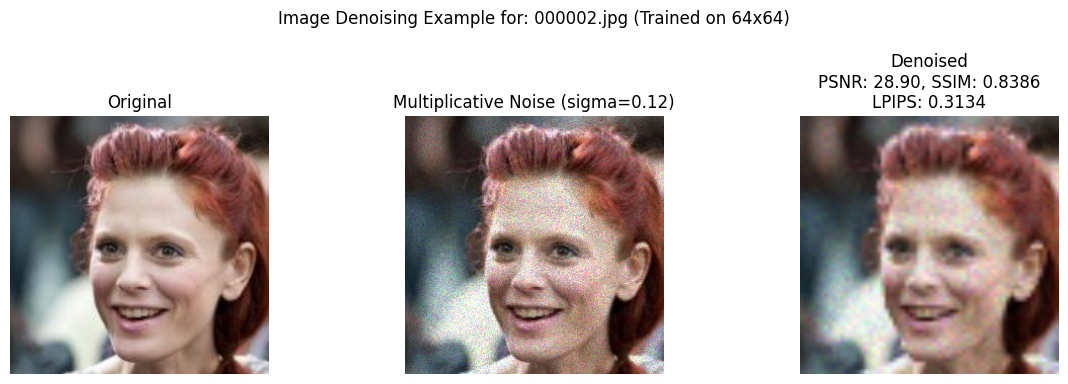

    PSNR: 28.90
    SSIM: 0.8386
    LPIPS: 0.3134

--- Average Metrics Over Test Images ---
Average PSNR: 28.90
Average SSIM: 0.8386
Average LPIPS: 0.3134


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import os
from PIL import Image
import math
import random

# Metrics
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import lpips
import matplotlib.pyplot as plt

# --- Constants ---
# Set the desired output/visualization image size
DISPLAY_IMAGE_SIZE = 256 # You want to see 256x256 output

# IMPORTANT: This must match the IMAGE_SIZE the model was TRAINED ON
# If your 'best_score_network (5).pth' was trained on 64x64, set this to 64
TRAINED_IMAGE_SIZE = 64
TRAINED_MODEL_HIDDEN_CHANNELS = 128 # Match hidden_channels from training

# K_TOTAL should be consistent with training. Assuming 1000 was used for the 64x64 model.
K_TOTAL = 1000
MULTIPLICATIVE_NOISE_SIGMA = 0.12 # Sigma for multiplicative noise (as used in previous training setup)

# --- Noise Schedule Calculation ---
MAX_LOG_DOMAIN_STD_DEV = MULTIPLICATIVE_NOISE_SIGMA

def sigma(k, K_total):
    """
    Modified noise schedule. This function defines the STANDARD DEVIATION of the
    additive Gaussian noise in the log domain at step k.
    It linearly scales from a very small value (or 0) up to MAX_LOG_DOMAIN_STD_DEV.
    sigma(0) should be 0.
    """
    if k == 0:
        return 0.0 # sigma at k=0 is 0 (clean image)
    return (k / K_total) * MAX_LOG_DOMAIN_STD_DEV

# --- Improved Score Network (U-Net inspired for image data) ---
# THIS CLASS MUST MATCH THE ARCHITECTURE USED DURING TRAINING
# For a 64x64 trained model, it typically has 3 down/up blocks
class ImprovedScoreNetwork(nn.Module):
    def __init__(self, channels=3, image_size=64, hidden_channels=128): # <--- Set image_size to 64 here
        super(ImprovedScoreNetwork, self).__init__()
        self.image_size = image_size
        self.channels = channels

        self.k_embedding = nn.Sequential(
            nn.Linear(1, hidden_channels * 8),
            nn.SiLU(),
            nn.Linear(hidden_channels * 8, hidden_channels * 4)
        )

        def conv_block(in_c, out_c, has_norm=True):
            layers = [
                nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU()
            ]
            return nn.Sequential(*layers)

        # Encoder path for 64x64 image (3 downsampling steps to 8x8 bottleneck)
        self.enc1 = conv_block(channels, hidden_channels)
        self.down1 = nn.MaxPool2d(2) # 64 -> 32

        self.enc2 = conv_block(hidden_channels, hidden_channels * 2)
        self.down2 = nn.MaxPool2d(2) # 32 -> 16

        self.enc3 = conv_block(hidden_channels * 2, hidden_channels * 4)
        self.down3 = nn.MaxPool2d(2) # 16 -> 8

        self.bottleneck_conv = conv_block(hidden_channels * 4, hidden_channels * 8)

        # Linear layer dimensions for 64x64 (image_size // 8)
        self.bottleneck_linear = nn.Sequential(
            nn.Linear(hidden_channels * 8 * (image_size // 8) * (image_size // 8) + hidden_channels * 4, hidden_channels * 8),
            nn.SiLU(),
            nn.Linear(hidden_channels * 8, hidden_channels * 8 * (image_size // 8) * (image_size // 8))
        )

        def up_block(in_c, out_c, has_norm=True):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_c) if has_norm else nn.Identity(),
                nn.SiLU()
            ]
            return nn.Sequential(*layers)

        # Decoder path for 64x64 image (3 upsampling steps)
        self.dec1 = up_block(hidden_channels * 8, hidden_channels * 4) # From bottleneck (8x8 -> 16x16)
        self.dec2 = up_block(hidden_channels * 4 * 2, hidden_channels * 2) # Skip from enc3 (16x16 -> 32x32)
        self.dec3 = up_block(hidden_channels * 2 * 2, hidden_channels) # Skip from enc2 (32x32 -> 64x64)

        self.output_conv = nn.Conv2d(hidden_channels * 2, channels, kernel_size=1) # Skip from enc1

    def forward(self, yk_flat, k):
        yk = yk_flat.view(-1, self.channels, self.image_size, self.image_size)

        k_emb = self.k_embedding(k.float().unsqueeze(1) / K_TOTAL)

        # Encoder
        e1 = self.enc1(yk) # -> 64x64
        d1 = self.down1(e1) # -> 32x32

        e2 = self.enc2(d1) # -> 32x32
        d2 = self.down2(e2) # -> 16x16

        e3 = self.enc3(d2) # -> 16x16
        d3 = self.down3(e3) # -> 8x8

        # Bottleneck
        b_conv = self.bottleneck_conv(d3) # -> 8x8
        b_flat = b_conv.view(b_conv.size(0), -1)

        b_combined = torch.cat([b_flat, k_emb], dim=1) # Concatenate k_emb
        b_linear_out = self.bottleneck_linear(b_combined)
        b_reshaped = b_linear_out.view(b_linear_out.size(0), -1, self.image_size // 8, self.image_size // 8)

        # Decoder with skip connections
        u1 = self.dec1(b_reshaped) # -> 16x16
        u2 = self.dec2(torch.cat([u1, e3], dim=1)) # Concatenate u1 and e3 -> 32x32
        u3 = self.dec3(torch.cat([u2, e2], dim=1)) # Concatenate u2 and e2 -> 64x64

        output = self.output_conv(torch.cat([u3, e1], dim=1)) # Concatenate u3 and e1 -> 64x64

        return output.view(output.size(0), -1)

# --- DDIM Noise Removal Procedure (following the algorithm with provided equations) ---
def ddim_denoise(corrupted_image_tensor_trained_size, score_network_model, K_total_steps, original_image_size):
    """
    Performs DDIM noise removal on a single corrupted image.
    Handles resizing of input/output to match the trained model's expected size.

    Args:
        corrupted_image_tensor_trained_size (torch.Tensor): The initial corrupted image in log-domain (yK),
                                                             ALREADY RESIZED to TRAINED_IMAGE_SIZE.
                                                             Expected shape: (1, -1) (flattened).
        score_network_model (nn.Module): The trained score network.
        K_total_steps (int): Total number of diffusion steps.
        original_image_size (int): The target output image size (e.g., DISPLAY_IMAGE_SIZE).
    Returns:
        torch.Tensor: Denoised image tensor, normalized to [-1, 1] and reshaped to original_image_size.
    """
    score_network_model.eval() # Set model to evaluation mode
    trained_image_size = score_network_model.image_size # Get the size the model expects

    with torch.no_grad():
        current_yk = corrupted_image_tensor_trained_size.clone().to(DEVICE)

        for k_step in range(K_total_steps, 0, -1):
            k_tensor = torch.tensor([k_step]).float().to(DEVICE)

            sigma_k = sigma(k_step, K_total_steps)
            sigma_k_minus_1 = sigma(k_step - 1, K_total_steps)

            sigma_k_t = torch.tensor(sigma_k, dtype=torch.float32).to(DEVICE)
            sigma_k_minus_1_t = torch.tensor(sigma_k_minus_1, dtype=torch.float32).to(DEVICE)

            eta_k_t = sigma_k_t**2
            eta_k_minus_1_t = eta_k_minus_1_t = sigma_k_minus_1_t**2 # Corrected typo here

            predicted_score = score_network_model(current_yk, k_tensor)

            y_hat_0 = current_yk + 0.5 * eta_k_t + eta_k_t * predicted_score

            term_in_bracket = current_yk - y_hat_0 + 0.5 * eta_k_t
            sqrt_eta_ratio_term = torch.sqrt(eta_k_minus_1_t) / (torch.sqrt(eta_k_t) + 1e-6)

            current_yk = y_hat_0 - 0.5 * eta_k_minus_1_t + sqrt_eta_ratio_term * term_in_bracket

        y_0 = current_yk # Final estimated noise-free image in log-domain

    denoised_x_hat_raw = torch.exp(y_0)
    denoised_x_hat_clamped_01 = torch.clamp(denoised_x_hat_raw, 0.0, 1.0)
    denoised_x_hat = (denoised_x_hat_clamped_01 * 2) - 1

    # Reshape back to the model's trained image size for now
    denoised_x_hat_reshaped_trained_size = denoised_x_hat.view(1, 3, trained_image_size, trained_image_size)

    # If trained_image_size is different from original_image_size, resize the output
    if trained_image_size != original_image_size:
        denoised_x_hat_final = torch.nn.functional.interpolate(
            denoised_x_hat_reshaped_trained_size,
            size=(original_image_size, original_image_size),
            mode='bilinear',
            align_corners=False
        )
    else:
        denoised_x_hat_final = denoised_x_hat_reshaped_trained_size

    return denoised_x_hat_final

# --- Image Preprocessing for Evaluation ---
# This transform will now resize to the TRAINED_IMAGE_SIZE for model input
# and also provide a transform for the DISPLAY_IMAGE_SIZE for original/noisy images
# which are shown at the desired resolution.

# Transform for preparing images for the TRAINED model input
transform_for_model_input = transforms.Compose([
    transforms.Resize(TRAINED_IMAGE_SIZE),
    transforms.CenterCrop(TRAINED_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to [-1, 1]
])

# Transform for original/noisy images at display resolution for metrics/visualization
transform_for_display_and_metrics = transforms.Compose([
    transforms.Resize(DISPLAY_IMAGE_SIZE),
    transforms.CenterCrop(DISPLAY_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to [-1, 1]
])


# --- Denoising and Metric Calculation with Visualization ---
def calculate_metrics_and_visualize(original_image_path, score_network_model, K_denoising_steps):
    original_pil_image = Image.open(original_image_path).convert('RGB')

    # Prepare original tensor for display/metrics (at DISPLAY_IMAGE_SIZE)
    original_tensor_display_size = transform_for_display_and_metrics(original_pil_image).unsqueeze(0).to(DEVICE) # Tensor in [-1, 1]

    # Prepare original tensor for noise addition (at DISPLAY_IMAGE_SIZE)
    original_for_noise_addition = (original_tensor_display_size + 1) / 2 # Now in [0, 1]

    # Add multiplicative noise: x_noisy = x_original * (1 + N(0, sigma_mult^2))
    multiplicative_noise_factor = torch.randn_like(original_for_noise_addition) * MULTIPLICATIVE_NOISE_SIGMA + 1.0
    corrupted_tensor_pixel_space_display_size = original_for_noise_addition * multiplicative_noise_factor
    corrupted_tensor_pixel_space_display_size = torch.clamp(corrupted_tensor_pixel_space_display_size, 0, 1) # Ensure it stays in [0, 1]

    # Convert corrupted image to model input range [-1, 1] and THEN resize to TRAINED_IMAGE_SIZE
    corrupted_tensor_model_input = (corrupted_tensor_pixel_space_display_size * 2) - 1 # Back to [-1, 1]

    # Resize the corrupted tensor to the TRAINED_IMAGE_SIZE before feeding to the model
    corrupted_tensor_for_model = torch.nn.functional.interpolate(
        corrupted_tensor_model_input,
        size=(TRAINED_IMAGE_SIZE, TRAINED_IMAGE_SIZE),
        mode='bilinear',
        align_corners=False
    ).to(DEVICE)

    # Convert corrupted image (now at TRAINED_IMAGE_SIZE) to log-domain for the score network input
    corrupted_for_log = (corrupted_tensor_for_model + 1) / 2 # Convert back to [0, 1] for log
    corrupted_flattened_yK = torch.log(torch.clamp(corrupted_for_log.view(1, -1), min=1e-6)) # Apply log and flatten, clamp for stability

    # Call ddim_denoise, passing the trained model's expected size for internal processing
    denoised_image_tensor = ddim_denoise(corrupted_flattened_yK, score_network_model, K_TOTAL, DISPLAY_IMAGE_SIZE)

    # Prepare images for display and metric calculation
    original_for_display = (original_tensor_display_size.squeeze(0).cpu().permute(1, 2, 0).numpy() + 1) / 2 # Convert to [0,1] for display
    corrupted_for_display = corrupted_tensor_pixel_space_display_size.squeeze(0).cpu().permute(1, 2, 0).numpy()
    denoised_for_display = (denoised_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy() + 1) / 2 # Convert to [0,1] for display

    # Metrics require float64 and [0,1] range
    original_for_metrics = original_for_display.astype(np.float64)
    denoised_for_metrics = denoised_for_display.astype(np.float64)

    # Ensure images have the same dimensions for metrics (they should if DISPLAY_IMAGE_SIZE is used consistently)
    psnr = psnr_metric(original_for_metrics, denoised_for_metrics, data_range=1.0)
    ssim = ssim_metric(original_for_metrics, denoised_for_metrics, data_range=1.0, channel_axis=-1)

    # LPIPS needs tensors in [-1, 1] and the same size
    lpips_val = lpips_model(original_tensor_display_size.to(DEVICE), denoised_image_tensor.to(DEVICE)).item()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_for_display)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(corrupted_for_display)
    axes[1].set_title(f"Multiplicative Noise (sigma={MULTIPLICATIVE_NOISE_SIGMA:.2f})")
    axes[1].axis('off')

    axes[2].imshow(denoised_for_display)
    axes[2].set_title(f"Denoised\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}\nLPIPS: {lpips_val:.4f}")
    axes[2].axis('off')

    plt.suptitle(f"Image Denoising Example for: {os.path.basename(original_image_path)} (Trained on {TRAINED_IMAGE_SIZE}x{TRAINED_IMAGE_SIZE})")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return psnr, ssim, lpips_val

# --- Main Denoising Execution and Evaluation ---
if __name__ == "__main__":
    # Use GPU if available
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Initialize LPIPS model for evaluation
    try:
        lpips_model = lpips.LPIPS(net='alex').to(DEVICE)
        lpips_model.eval()
    except Exception as e:
        print(f"Error initializing LPIPS model: {e}")
        print("Please ensure 'lpips' library is installed and 'alexnet' weights can be downloaded.")
        exit()

    # !!! MODEL_PATH IS NOW SET TO YOUR SPECIFIED PATH !!!
    MODEL_PATH = "/content/best_score_network (5).pth"
    DATA_PATH = "/content/img_align_celeba/img_align_celeba" # Path to your CelebA dataset

    # Instantiate the Score Network with the *TRAINED* architecture
    # This is crucial: image_size and hidden_channels must match the model you are loading
    score_network_eval = ImprovedScoreNetwork(channels=3, image_size=TRAINED_IMAGE_SIZE, hidden_channels=TRAINED_MODEL_HIDDEN_CHANNELS).to(DEVICE)

    try:
        # Load the state_dict from the trained model
        score_network_eval.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print(f"\nModel loaded successfully for evaluation from {MODEL_PATH}")
    except FileNotFoundError:
        print(f"\nError: Model not found at {MODEL_PATH}.")
        print("Please ensure the model is trained and saved in the correct directory, or check the path.")
        exit()
    except RuntimeError as e:
        print(f"\nRuntimeError during model loading: {e}")
        print("This often means the model architecture (e.g., hidden_channels, number of layers) does not match the saved weights,")
        print("OR the .pth file itself is corrupted/incomplete.")
        print(f"Current model configured for TRAINED_IMAGE_SIZE={TRAINED_IMAGE_SIZE}, hidden_channels={TRAINED_MODEL_HIDDEN_CHANNELS}.")
        print("Please verify that these parameters match those of your trained model, and that the .pth file is valid.")
        exit()

    score_network_eval.eval()

    # --- Test image modification ---
    test_image_path = os.path.join(DATA_PATH, "000002.jpg") # Original image might be 256x256 or larger
    test_image_files = [test_image_path]

    if not os.path.exists(test_image_path):
        print(f"Error: The specified test image '{test_image_path}' does not exist. Please verify the path.")
        exit()

    print(f"\nPerforming denoising and evaluation on the specified image: {os.path.basename(test_image_path)}")

    all_psnr = []
    all_ssim = []
    all_lpips = []

    for i, img_file_path in enumerate(test_image_files):
        print(f"\nProcessing image {i+1}/{len(test_image_files)}: {os.path.basename(img_file_path)}")

        psnr, ssim, lpips_val = calculate_metrics_and_visualize(img_file_path, score_network_eval, K_TOTAL)

        all_psnr.append(psnr)
        all_ssim.append(ssim)
        all_lpips.append(lpips_val)

        print(f"    PSNR: {psnr:.2f}")
        print(f"    SSIM: {ssim:.4f}")
        print(f"    LPIPS: {lpips_val:.4f}")

    print("\n--- Average Metrics Over Test Images ---")
    print(f"Average PSNR: {np.mean(all_psnr):.2f}")
    print(f"Average SSIM: {np.mean(all_ssim):.4f}")
    print(f"Average LPIPS: {np.mean(all_lpips):.4f}")

This DDIM model is giving inccompetent result due to insufficient training .We need to train it more for better outcome.Unfortunately,I can't be able to train it properly as my work is not solely comprised of this  model.

This is for segregating images upto certain extent from the whole dataset

In [ ]:
import os
from PIL import Image
import random
import shutil

# Define paths
source_dataset_path = '/content/img_align_celeba/img_align_celeba'
output_subset_path = '/content/celeba_100_subset_64x64'
target_resolution = (64, 64)
num_images_to_select = 10000

# Create the output directory if it doesn't exist
os.makedirs(output_subset_path, exist_ok=True)

# List all image files in the source directory
all_image_files = [f for f in os.listdir(source_dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle and select 100 images
if len(all_image_files) > num_images_to_select:
    selected_images = random.sample(all_image_files, num_images_to_select)
else:
    selected_images = all_image_files
    print(f"Warning: Only {len(all_image_files)} images found, selecting all of them.")

print(f"Processing {len(selected_images)} images...")

# Process and save the selected images
for i, image_filename in enumerate(selected_images):
    input_image_path = os.path.join(source_dataset_path, image_filename)
    output_image_path = os.path.join(output_subset_path, f'image_{i:04d}.png') # Save as PNG for consistency

    try:
        with Image.open(input_image_path) as img:
            img_resized = img.resize(target_resolution, Image.LANCZOS)
            img_resized.save(output_image_path)
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(selected_images)} images.")
    except Exception as e:
        print(f"Error processing {image_filename}: {e}")

print(f"\n{len(selected_images)} images processed and saved to: {output_subset_path}")

Processing 10000 images...
Processed 10/10000 images.
Processed 20/10000 images.
Processed 30/10000 images.
Processed 40/10000 images.
Processed 50/10000 images.
Processed 60/10000 images.
Processed 70/10000 images.
Processed 80/10000 images.
Processed 90/10000 images.
Processed 100/10000 images.
Processed 110/10000 images.
Processed 120/10000 images.
Processed 130/10000 images.
Processed 140/10000 images.
Processed 150/10000 images.
Processed 160/10000 images.
Processed 170/10000 images.
Processed 180/10000 images.
Processed 190/10000 images.
Processed 200/10000 images.
Processed 210/10000 images.
Processed 220/10000 images.
Processed 230/10000 images.
Processed 240/10000 images.
Processed 250/10000 images.
Processed 260/10000 images.
Processed 270/10000 images.
Processed 280/10000 images.
Processed 290/10000 images.
Processed 300/10000 images.
Processed 310/10000 images.
Processed 320/10000 images.
Processed 330/10000 images.
Processed 340/10000 images.
Processed 350/10000 images.
Pr